# Capstone Project: Audio Based Emotion Classifier - Exploratory Notebook

## Set Path to Project Folder

In [1]:
# Set PATH to 'Classifying Emotions With Audio' directory
# Make sure this folder contains 'Data Sets' with TESS and SAVEE inside, as well as the 'Models' Folder
PATH = '/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Classifying Emotions With Audio/'

## Import libraries

In [2]:
# Standard Library Imports
import csv
import os
import numpy as np
import pandas as pd
import re
import librosa
from librosa import display
import IPython.display as ipd
from IPython.display import display
import time
import pickle
import seaborn as sn
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io.wavfile import write

#Keras Imports
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Dense, 
                                     Conv2D, 
                                     MaxPooling1D, 
                                     MaxPooling2D, 
                                     Flatten, 
                                     Dense, 
                                     Dropout,
                                     Conv1D, 
                                     Activation, 
                                     BatchNormalization, 
                                     AveragePooling1D,
                                     MaxPool1D,
                                     GlobalMaxPool2D,
                                     LSTM,
                                     Bidirectional,
                                     Embedding,
                                     GRU,
                                     SimpleRNN
                                    )
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import (EarlyStopping, 
                                        LearningRateScheduler,
                                        ModelCheckpoint, 
                                        TensorBoard, 
                                        ReduceLROnPlateau)

from tensorflow.keras import optimizers
from keras import callbacks

from tensorflow.keras.utils import to_categorical

# SKLearn Imports
from sklearn.metrics import (confusion_matrix, 
                             accuracy_score, 
                             classification_report)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, RandomTreesEmbedding
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix


/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Classifying Emotions With Audio/Capstone_env/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Classifying Emotions With Audio/Capstone_env/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_j

## Part 1

### Preprocessing

#### Extracting The Data

In [4]:
%%time
# This script will build a dataframe consisting of some basic information about each file in the two datasets we are using at this point: TESS and SAVEE

# 0 = anger, 1 = disgust, 2 = fear, 3 = sad, 4 = neutral, 5 = happy , 6 = surprised

# Making a list of datasets
data_sets = []
with os.scandir(os.path.join(PATH, 'Data Sets')) as entries:
    for entry in entries:
        if entry.name != ('.DS_Store'):
            data_sets.append(entry.name)

# Making a list of speakers in SAVEE dataset
speakers = []
with os.scandir(os.path.join(PATH, 'Data Sets', data_sets[0])) as entries:
    for entry in entries:
        if len(entry.name) == 2:
            speakers.append(entry.name)

            
# Creating a new dataframe for the audiofile information.
audiodata = pd.DataFrame()
audiodata['Filename'] = 'default'
audiodata['Dataset'] = 'default'
audiodata['Sex'] = 'default'
audiodata['Speaker'] = 'default'
audiodata['Duration'] = 'default'
audiodata['Emotion'] = 'default'
            
# Defining a function to assign numeric values to each emotion specified in SAVEE dataset            
def emotion(name):
    
    x = 0
    if re.search('^a', name):
        x = 0
    if re.search('^d', name):
        x = 1
    if re.search('^f', name):
        x = 2
    if re.search('^sa', name):
        x = 3
    if re.search('^n', name):
        x = 4
    if re.search('^h', name):
        x = 5
    if re.search('^su', name):
        x = 6
    
    return x

count = 0
    
# Iterating through the files in SAVEE and extracting key information.
for i in speakers:
    with os.scandir(os.path.join(PATH, 'Data Sets', data_sets[0], i)) as entries:
        for entry in entries:
            filename = str(entry.name)
            x = emotion(filename)
            duration = round(librosa.get_duration(filename=os.path.join(PATH, 'Data Sets', data_sets[0],i, filename)), 2)
            audiodata = audiodata.append({'Filename':filename, 
                                          'Dataset':data_sets[0], 
                                          'Sex':'M', 
                                          'Speaker': i,
                                          'Duration': duration,
                                          'Emotion':x}, ignore_index=True)
            count+=1
            print('\r',f'{count} files added',end='')

audiodata.drop_duplicates(subset = ["Filename", "Speaker"],inplace = True, keep = 'last')       

# Second function for assigning numeric values for emotions in TESS dataset
def emotion1(name):
    
    speaker = str
    x = int
    if re.search('^YAF', name):
        speaker = 'YAF'
    if re.search('^OAF', name):
        speaker = 'OAF'
    if re.search('angry', name):
        x = 0
    if re.search('disgust', name):
        x = 1
    if re.search('fear', name):
        x = 2
    if re.search('sad', name):
        x = 3
    if re.search('neutral', name):
        x = 4
    if re.search('happy', name):
        x = 5
    if re.search('ps', name[-6:]):
        x = 6
    return (x, speaker)

# Iterating through the files in TESS and extracting key information.
with os.scandir(os.path.join(PATH, 'Data Sets', data_sets[1])) as entries:
    for entry in entries:
        folder = entry.name
        if folder != '.DS_Store':
            
            with os.scandir(os.path.join(PATH, 'Data Sets', data_sets[1], folder)) as entries1:
                for i in entries1:
                    filename = i.name
                    x, speaker = emotion1(filename)
                    duration = round(librosa.get_duration(filename=os.path.join(PATH, 'Data Sets', data_sets[1],folder, filename)), 2)
                    audiodata = audiodata.append({'Filename':filename, 
                                          'Dataset':data_sets[1], 
                                          'Sex':'F', 
                                          'Speaker': speaker,
                                          'Duration': duration,
                                          'Emotion':x}, ignore_index=True)
                    count+=1
                    print('\r',f'{count} files added',end='')

audiodata.drop_duplicates(subset = ["Filename", "Speaker"],inplace = True, keep = 'last')
audiodata.reset_index(inplace = True, drop = True)


# Saving our dataframe in a new directory called 'DataFrames'
if not os.path.exists(os.path.join(PATH,'DataFrames')):
    os.makedirs(os.path.join(PATH,'DataFrames'))

os.chdir(os.path.join(PATH,'DataFrames'))
audiodata.to_csv('Audio Data Raw.csv', index=False)
audiodata = pd.read_csv('Audio Data Raw.csv', index_col=False)
audiodata

 3280 files addedCPU times: user 14 s, sys: 1.05 s, total: 15.1 s
Wall time: 15.8 s


Filename Dataset Sex Speaker  Duration  Emotion
0               n17.wav   SAVEE   M      KL      2.61        4
1               n03.wav   SAVEE   M      KL      1.65        4
2               h05.wav   SAVEE   M      KL      3.38        5
3              sa04.wav   SAVEE   M      KL      4.73        3
4               h11.wav   SAVEE   M      KL      5.53        5
...                 ...     ...  ..     ...       ...      ...
3275   OAF_tool_sad.wav    TESS   F     OAF      2.56        3
3276  OAF_goose_sad.wav    TESS   F     OAF      2.52        3
3277    OAF_met_sad.wav    TESS   F     OAF      2.44        3
3278  OAF_pearl_sad.wav    TESS   F     OAF      2.40        3
3279   OAF_rain_sad.wav    TESS   F     OAF      2.26        3

[3280 rows x 6 columns]

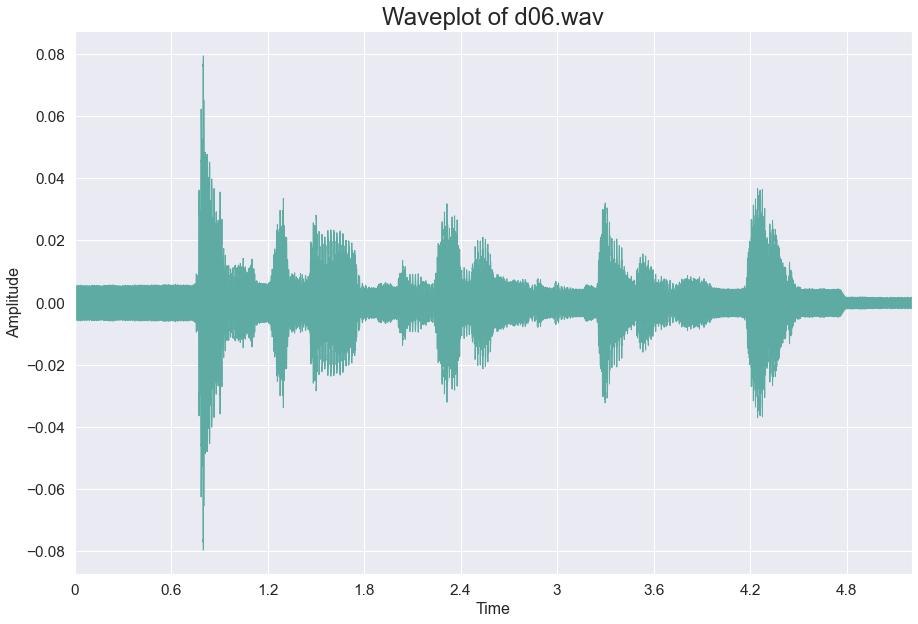

In [180]:
# Plotting a random audio file from our dataframe
os.chdir(os.path.join(PATH,'Data Sets'))

n = np.random.randint(0,479)

filename = audiodata.iloc[n,0]
dataset = audiodata.iloc[n,1]
speaker = audiodata.iloc[n,3]

audio, sr= librosa.load((os.path.join(dataset,speaker,filename)), sr=41000)


plt.figure(figsize=(15,10), edgecolor='#020404')
librosa.display.waveplot(y=np.trim_zeros((audio),'b'), color = '#5eaba3')
plt.title(f'Waveplot of {filename}', fontsize=24)
plt.xlabel("Time", fontsize=16 )
plt.ylabel("Amplitude", fontsize=16)

if not os.path.exists(os.path.join(PATH,'Presentation Materials')):
    os.makedirs(os.path.join(PATH,'Presentation Materials'))
os.chdir(os.path.join(PATH,'Presentation Materials'))
plt.savefig(f'Waveplot of {filename[:-4]}')

plt.show()

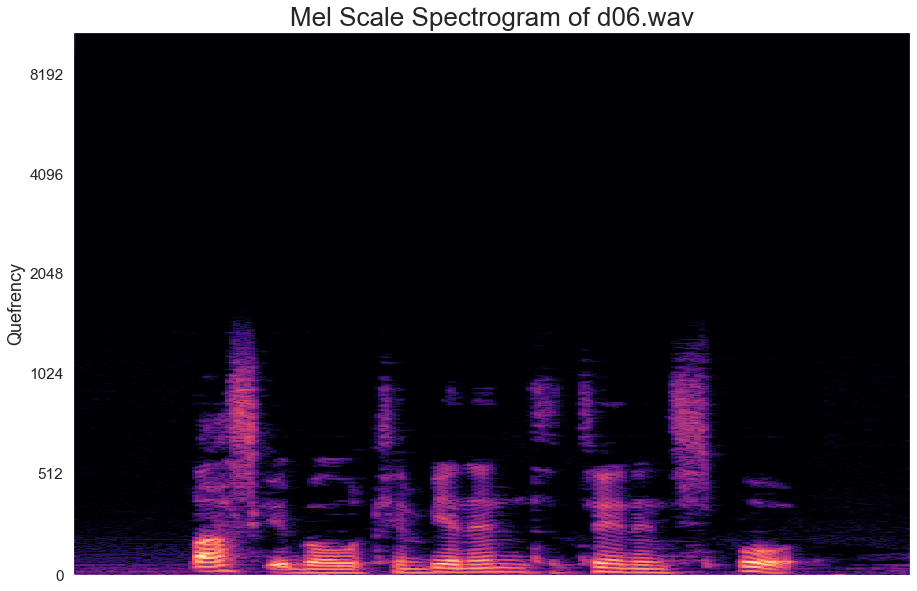

In [181]:
# Plotting the same file's spectrogram plotted on the mel scale
D = librosa.amplitude_to_db(np.abs(librosa.stft(np.trim_zeros((audio),'b'))), ref=np.max)
plt.figure(figsize=(15,10))
librosa.display.specshow(data=D, y_axis='mel')
plt.title(f'Mel Scale Spectrogram of {filename}', fontsize=26)
plt.ylabel("Quefrency", fontsize=18)
plt.savefig(f'Mel Scale Spectrogram of {filename[:-4]}')
plt.show()

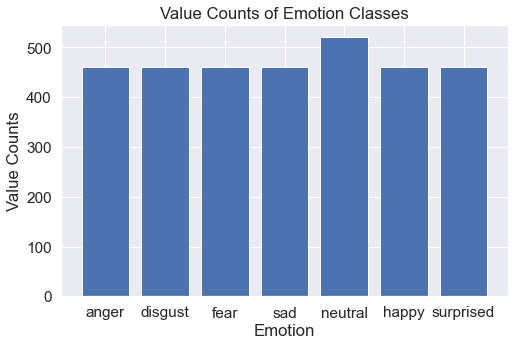

In [182]:
# Assessing the balance of classes
plt.figure(figsize=(8,5))
plt.bar(audiodata['Emotion'].unique(), audiodata['Emotion'].value_counts())
plt.xticks([0,1,2,3,4,5,6], ['anger','disgust','fear','sad','neutral','happy','surprised'])
plt.xlabel('Emotion')
plt.ylabel('Value Counts')
plt.title('Value Counts of Emotion Classes')
plt.savefig('Value Counts of Emotional Classes')
plt.show()

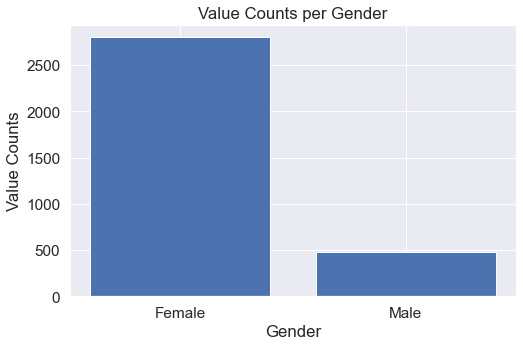

In [183]:
# Assessing the balance of classes
plt.figure(figsize=(8,5))
plt.bar(audiodata['Sex'].unique(), audiodata['Sex'].value_counts())
plt.xticks([0,1], ['Female','Male'])
plt.xlabel('Gender')
plt.ylabel('Value Counts')
plt.title('Value Counts per Gender')
plt.savefig('Value Counts of Gender')
plt.show()


#### Balancing our Data

In [7]:
# Downsampling neutral utterances by male speakers from SAVEE dataset

audiodatabalanced_m = resample(audiodata[audiodata['Emotion']==4][audiodata['Sex']=='M'], 
                               n_samples=60,
                               random_state = 18
                                )
audiodatabalanced_m = pd.concat((audiodata[audiodata['Emotion']!=4][audiodata['Sex']=='M'], audiodatabalanced_m))
audiodatabalanced_m = audiodatabalanced_m.reset_index(drop=True)


# Resampling utterances by female speakers to balance male and female, while stratifying to maintain balance of emotional classes.

audiodatabalanced_f = resample(audiodata[audiodata['Sex']=='F'], 
                               n_samples=audiodatabalanced_m.shape[0], 
                               stratify = audiodata[audiodata['Sex']=='F']['Emotion'],
                               random_state = 18
                                )

# Joining balanced male and female dataframes.
audiodata_balanced = pd.concat((audiodatabalanced_m,audiodatabalanced_f)).reset_index(drop=True)
audiodata_balanced['Emotion'].value_counts()

# Outputting our balanced data as a CSV to use later.
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced.to_csv("Balanced Audio Data.csv", index=False)
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)
audiodata_balanced.sample(10)

<ipython-input-7-56f2a8335fcd>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  audiodatabalanced_m = resample(audiodata[audiodata['Emotion']==4][audiodata['Sex']=='M'],
<ipython-input-7-56f2a8335fcd>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  audiodatabalanced_m = pd.concat((audiodata[audiodata['Emotion']!=4][audiodata['Sex']=='M'], audiodatabalanced_m))


Filename Dataset Sex Speaker  Duration  Emotion
665        OAF_gas_ps.wav    TESS   F     OAF      2.40        6
479     OAF_dodge_sad.wav    TESS   F     OAF      2.49        3
577   YAF_dodge_angry.wav    TESS   F     YAF      2.38        0
83                d10.wav   SAVEE   M      KL      3.43        1
84                d11.wav   SAVEE   M      KL      3.17        1
637  YAF_rush_disgust.wav    TESS   F     YAF      2.75        1
246               d02.wav   SAVEE   M      JE      3.54        1
451    YAF_ring_happy.wav    TESS   F     YAF      1.91        5
735   YAF_witch_angry.wav    TESS   F     YAF      2.20        0
403               n26.wav   SAVEE   M      DC      3.13        4

#### Extracting 40 MFCCs Averaged Over Time

We're going to start with extracting 40 MFCCs per audio file, and then averaging each of those 40 MFCCs over time. Initial experiments compared modelling performance with just 13 MFCCs, and with averaging the MFCCs themselves, and not taking the averages over time for each coefficient. After preliminary experimentations we found that working with the mean over time of 40 MFCCs was the most effecient and effective format of data for our models to be able to work with. If you are running this notebook yourself you can experiment with different numbers of MFCCs by changing the n_MFCCs variable in the cell below.

In [8]:
# This script will extract 40 MFCCs averaged over time per file listed in "Balanced Audio Data.csv"

os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)

#Change this to test models with different numbers of MFCCs extracted
n_MFCCs = 40

start_time = time.time()
MFCC_df = pd.DataFrame()
os.chdir(os.path.join(PATH,'Data Sets'))

# A function to help us access the file structure of TESS dataset
def emotion_reverse(emotion):
    
    x = str
    if emotion == 0:
        x = 'angry'
    if emotion == 1:
        x = 'disgust'
    if emotion == 2:
        x = 'fear'
    if emotion == 3:
        x = 'sad'
    if emotion == 4:
        x = 'neutral'
    if emotion == 5:
        x = 'happy'
    if emotion == 6:
        x = 'pleasant_surprised'
    return (x)

#Iterating through each audio file in our dataset and extracting 40 MFCCs
for n in range(0,audiodata_balanced.shape[0]):
    
    filename = audiodata_balanced.iloc[n]['Filename']
    dataset = audiodata_balanced.iloc[n]['Dataset']
    speaker = audiodata_balanced.iloc[n]['Speaker']
    emotion = audiodata_balanced.iloc[n]['Emotion']
    
    if (dataset=='SAVEE'):
        y, sr = librosa.load(os.path.join(dataset, speaker, filename), sr = 41000)
    elif(dataset=='TESS'):
        emotion = emotion_reverse(emotion)
        speaker_emotion = (f'{speaker}_{emotion}')
        y, sr = librosa.load(os.path.join(dataset, speaker_emotion, filename), sr = 41000)
    
    mfcc_test = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = n_MFCCs, hop_length = 128)
    mfcc_test = pd.Series(np.mean(mfcc_test, axis=1))
    MFCC_df = MFCC_df.append(mfcc_test, ignore_index=True)
    
    print('\r',f'{n+1}/{(audiodata_balanced.shape[0])} completed', end='')
    

audiodata_balanced_w_mfcc = pd.concat((audiodata_balanced, MFCC_df), ignore_index=True, axis=1)
print(f'Time to run: {time.time()-start_time}')

# Saving our data with 40 MFCCs per file
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced_w_mfcc.to_csv("Balanced Audio Data with 40 MFCCs.csv", index=False)

 840/840 completedTime to run: 108.12669277191162


#### Splitting our Data Into Train/Test and Scaling

In [9]:
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced_w_mfcc = pd.read_csv("Balanced Audio Data with 40 MFCCs.csv", index_col=False)
audiodata_balanced_w_mfcc.sample(20)

0      1  2    3     4  5          6           7  \
710       OAF_base_sad.wav   TESS  F  OAF  2.57  3 -557.84390  101.941826   
694   OAF_goal_disgust.wav   TESS  F  OAF  2.42  1 -519.55000  129.303670   
69                 f15.wav  SAVEE  M   KL  4.79  2 -605.74360  117.969154   
294               sa01.wav  SAVEE  M   JK  4.51  3 -380.04312  119.929980   
445        OAF_met_sad.wav   TESS  F  OAF  2.44  3 -539.88280  114.371430   
679  YAF_chief_disgust.wav   TESS  F  YAF  2.53  1 -468.51984   88.708060   
384                n22.wav  SAVEE  M   JK  3.11  4 -426.58510  119.406850   
793   YAF_loaf_disgust.wav   TESS  F  YAF  2.43  1 -435.86832  102.282780   
251                f05.wav  SAVEE  M   JE  3.98  2 -355.60416   89.538620   
219                a07.wav  SAVEE  M   JE  3.09  0 -300.82526  108.292800   
703   OAF_size_neutral.wav   TESS  F  OAF  2.24  4 -526.36066  112.553100   
338                f01.wav  SAVEE  M   JK  4.14  2 -282.96994  109.871940   
638   OAF_join_neutral.wav   TESS  F  OAF  2.24  4 -576.81270  112.276880   
761         YAF_yes_ps.wav   TESS  F  YAF  2.30  6 -393.22485   82.265810   
283                h06.wav  SAVEE  M   JK  3.67  5 -294.82272  117.730650   
40                su14.wav  SAVEE  M   KL  5.27  6 -580.89090  100.562256   
436        OAF_good_ps.wav   TESS  F  OAF  1.80  6 -455.57758  123.534280   
582        YAF_nag_sad.wav   TESS  F  YAF  2.31  3 -410.04040  116.311790   
757  OAF_tough_neutral.wav   TESS  F  OAF  1.91  4 -535.73450  117.666410   
314                a04.wav  SAVEE  M   JK  3.52  0 -308.10904  103.754400   

             8          9  ...        36        37        38        39  \
710  10.754365  42.490803  ... -3.467395 -0.779760 -1.505351  0.022222   
694  24.784857  41.151226  ...  1.458208  0.215487  0.900145  0.377773   
69   39.578876  34.513546  ...  1.014132 -2.019627 -1.127287  0.851042   
294  15.947178  42.623295  ...  1.364147  0.794404  0.447446  0.531753   
445  15.967350  33.270980  ... -0.618593  5.157552  4.121876  6.158629   
679 -40.560196  60.201210  ... -0.187911  1.160217  2.944179  3.979838   
384  46.881924  40.051334  ... -0.499072  2.071002  2.138951  0.403306   
793 -18.166542  34.895126  ... -0.447925  2.358543  0.013049  3.060814   
251  11.457165  28.061375  ...  3.979220  4.457482  3.415413  1.650096   
219   2.622151  15.117106  ... -0.979604 -0.935977 -0.590449 -1.648494   
703  -9.638216  49.548040  ... -1.318013  0.455830 -2.493160 -1.284373   
338  -4.470141  27.136984  ...  4.135844  6.665380  5.693768  1.983627   
638   7.096027  37.640600  ... -4.453392 -3.767529 -0.057066  1.926582   
761 -29.597155  40.452274  ... -4.020284  1.842203 -1.275094  1.540011   
283   7.672020  25.220337  ...  0.718845  3.529545  4.506397  3.238088   
40   33.424800  24.582228  ...  0.507586 -0.637500 -0.427152 -0.370213   
436  -4.036646  31.450073  ... -2.700799 -0.598146  3.198287  0.971533   
582  -8.192052  62.975872  ...  0.972710 -2.226344 -7.034791  3.099524   
757  -9.078177  40.772697  ... -2.648084 -0.859731 -3.188955  1.145434   
314  10.243547  23.208277  ... -0.496803  0.879777  0.871268 -0.222746   

           40        41        42        43        44        45  
710  5.016060  7.908732  7.498972  9.787052  8.145808  4.959691  
694 -1.695200  0.165851 -2.345480  0.207146  1.030798 -0.417543  
69   0.902389 -0.642056 -0.501301 -0.258108 -1.412144  0.050080  
294 -0.293191  0.712429  2.832643  2.633532  1.003473 -0.084625  
445  6.508105  5.015445  5.545700  1.499261 -1.128827  1.106017  
679 -0.278496  5.843866 -1.892961  3.739832  1.576240 -1.348121  
384  1.342417  1.794439  0.871774  1.308736  2.029388  1.619816  
793 -1.843654 -0.314542 -2.126345  1.108415  0.825966  0.538421  
251  1.953429  1.962673  2.995334  5.320013  3.945383  1.742089  
219  0.140964  1.044091  1.072015  2.068274  1.682700  2.318534  
703 -4.035755 -4.317568 -7.680835 -1.523130 -2.658740  4.225267  
338  4.817785  6.367585  3.860520  3.446211  3.414665  3.212

In [10]:
# Selecting X & y and splitting into train/test
X = audiodata_balanced_w_mfcc.iloc[:,6:]
y = audiodata_balanced_w_mfcc.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)

# Scaling and transforming
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

if not os.path.exists(os.path.join(PATH,'Training Data')):
    os.makedirs(os.path.join(PATH,'Training Data'))
    
os.chdir(os.path.join(PATH,'Training Data'))
y_test.to_csv('y_test')

### Initial Models

In [11]:
# Creating a dataframe to record each model's performance
prelimscores = pd.DataFrame(columns =['Model','Feature', 'Training Accuracy', 'Test Accuracy','Precision','Recall', 'F1'])

#### Logistic Regression

In [12]:
# Looping through LogRegs to optimize C value
for x in range(0,4):
    
    c = 10**x

    logreg = LogisticRegressionCV(Cs=c,cv=5, max_iter=10000)

    logreg.fit(X_train_scaled,y_train)
    
    print(f' C = {c}')

    print(logreg.score(X_train_scaled,y_train))

    print(logreg.score(X_test_scaled, y_test), end='\n')

 C = 1
0.4574829931972789
0.4722222222222222
 C = 10
0.8282312925170068
0.7341269841269841
 C = 100
0.8282312925170068
0.7420634920634921
 C = 1000
0.8282312925170068
0.7341269841269841


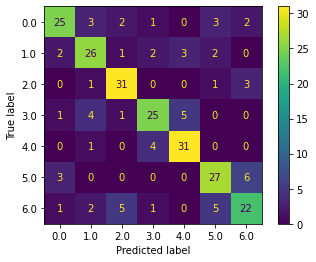

In [13]:
# Recording the accuracy of the LogReg with an optimal C value
logreg = LogisticRegressionCV(Cs=100,cv=5, max_iter=10000)

logreg.fit(X_train_scaled,y_train)
    
train_score = logreg.score(X_train_scaled, y_train)
test_score = logreg.score(X_test_scaled, y_test)

y_pred = logreg.predict(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

display(plot_confusion_matrix(logreg, X_test_scaled, y_test))

prelimscores = prelimscores.append({'Model': 'Logistic Regression',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(inplace=True)

#### SVMs

##### Linear SVM

In [14]:
# Looping through Linear SVMs to optimize C. We're going to try a few types of SVM
c = range(-5,5)

scores = pd.DataFrame(columns = ['C', 'Train Score', 'Test Score'])

for n in c:
    C=10**n

    SVM_model = LinearSVC(C=C, max_iter=10000)
    SVM_model.fit(X_train_scaled, y_train)
    
    train_score = SVM_model.score(X_train_scaled,y_train)
    test_score = SVM_model.score(X_test_scaled,y_test)

    scores = scores.append({'C':C, 'Train Score': train_score, 'Test Score': test_score}, ignore_index=True)

display(scores)

/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Classifying Emotions With Audio/Capstone_env/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Classifying Emotions With Audio/Capstone_env/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Classifying Emotions With Audio/Capstone_env/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/coleslatt/Documents/Data Scien

C  Train Score  Test Score
0      0.00001     0.457483    0.476190
1      0.00010     0.496599    0.511905
2      0.00100     0.596939    0.587302
3      0.01000     0.680272    0.686508
4      0.10000     0.746599    0.738095
5      1.00000     0.773810    0.734127
6     10.00000     0.773810    0.730159
7    100.00000     0.768707    0.738095
8   1000.00000     0.574830    0.567460
9  10000.00000     0.568027    0.603175

/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Classifying Emotions With Audio/Capstone_env/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Model        Feature  Training Accuracy  Test Accuracy  \
0  Logistic Regression  40 Mean MFCCs           0.828231       0.742063   
1           Linear SVM  40 Mean MFCCs           0.799320       0.694444   

   Precision    Recall        F1  
0   0.741228  0.742063  0.740304  
1   0.698235  0.694444  0.690156

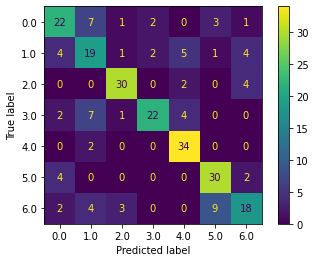

In [15]:
# Recording the score of a LinearSVC with C optimized
SVM_model = LinearSVC(C=100, max_iter=10000)
SVM_model.fit(X_train_scaled, y_train)
    
train_score = SVM_model.score(X_train_scaled,y_train)
test_score = SVM_model.score(X_test_scaled,y_test)

y_pred = SVM_model.predict(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

display(plot_confusion_matrix(SVM_model, X_test_scaled, y_test))

prelimscores = prelimscores.append({'Model': 'Linear SVM',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = 'Model', inplace=True)
prelimscores

With C=0, a linear SVM scores 78.9% accuracy on the test set.

##### RBF Kernel SVM

In [16]:
# Testing a RBF kernel SVM with a manually optimized C value
my_RBF_kernel_SVM = SVC(C=70, max_iter = 10000, probability=True)

my_RBF_kernel_SVM.fit(X_train_scaled, y_train)

train_score =  my_RBF_kernel_SVM.score(X_train_scaled, y_train)
test_score =  my_RBF_kernel_SVM.score(X_test_scaled, y_test)

print('Train score:', train_score)
print('Test score:', test_score)                                     
                                    

Train score: 1.0
Test score: 0.8849206349206349


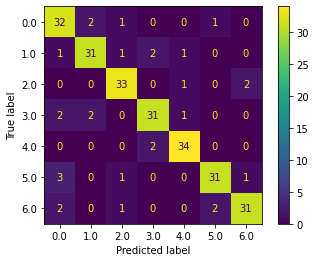

In [17]:
# Recording scores and viewing the confusion matrix
y_pred = my_RBF_kernel_SVM.predict(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

display(plot_confusion_matrix(my_RBF_kernel_SVM, X_test_scaled, y_test))

prelimscores = prelimscores.append({'Model': 'RBF Kernel SVM',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = 'Model', inplace=True, keep='last')

In [18]:
# Saving the predictions as this is a high performing model
if not os.path.exists(os.path.join(PATH,'Predictions')):
    os.makedirs(os.path.join(PATH,'Predictions'))

os.chdir(os.path.join(PATH,'Predictions'))
Top_SVM_Predict_Proba = my_RBF_kernel_SVM.predict_proba(X_test_scaled)

np.save("40 MFCCs Mean Kernel SVM Prediction Probabilities.npy",Top_SVM_Predict_Proba)

In [19]:
# # This saves the RBF Kernel Model for later use

# os.chdir('/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Models')
# filename = '40 MFCCs RBF Kernel.sav'
# pickle.dump(my_RBF_kernel_SVM, open(filename, 'wb'))

##### Poly Kernel SVM

In [20]:
# Testing a poly kernel SVM
for d in range(1,7):    
    
    my_RBF_kernel_SVM = SVC(kernel = 'poly', C=100, max_iter = 10000, degree = d)

    my_RBF_kernel_SVM.fit(X_train_scaled, y_train)
    
    print(f'Degree:{d}')

    print (f'Train score: {my_RBF_kernel_SVM.score(X_train_scaled, y_train)}')
    print (f'Test score: {my_RBF_kernel_SVM.score(X_test_scaled, y_test)}')
    print('\n')

/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Classifying Emotions With Audio/Capstone_env/lib/python3.8/site-packages/sklearn/svm/_base.py:228: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


Degree:1
Train score: 0.9081632653061225
Test score: 0.7222222222222222


Degree:2
Train score: 1.0
Test score: 0.7857142857142857


Degree:3
Train score: 1.0
Test score: 0.8373015873015873


Degree:4
Train score: 1.0
Test score: 0.7936507936507936


Degree:5
Train score: 0.9948979591836735
Test score: 0.8055555555555556


Degree:6
Train score: 0.9642857142857143
Test score: 0.746031746031746




Model        Feature  Training Accuracy  Test Accuracy  \
0  Logistic Regression  40 Mean MFCCs           0.828231       0.742063   
1           Linear SVM  40 Mean MFCCs           0.799320       0.694444   
2       RBF Kernel SVM  40 Mean MFCCs           1.000000       0.884921   
3      Poly Kernel SVM  40 Mean MFCCs           0.994898       0.805556   

   Precision    Recall        F1  
0   0.741228  0.742063  0.740304  
1   0.698235  0.694444  0.690156  
2   0.886538  0.884921  0.885090  
3   0.818079  0.805556  0.806077

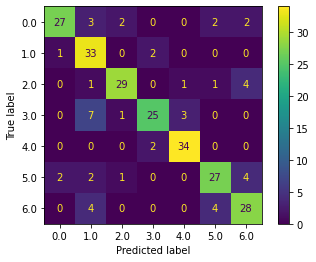

In [21]:
# Recording scores and viewing the confusion matrix
my_RBF_kernel_SVM = SVC(kernel = 'poly', C=100, max_iter = 10000, degree = 5, probability=True)
my_RBF_kernel_SVM.fit(X_train_scaled, y_train)

train_score =  my_RBF_kernel_SVM.score(X_train_scaled, y_train)
test_score =  my_RBF_kernel_SVM.score(X_test_scaled, y_test)

y_pred = my_RBF_kernel_SVM.predict(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

display(plot_confusion_matrix(my_RBF_kernel_SVM, X_test_scaled, y_test))

prelimscores = prelimscores.append({'Model': 'Poly Kernel SVM',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = 'Model', inplace=True, keep='last')
prelimscores

In [22]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))
Top_SVM_Predict_Proba = my_RBF_kernel_SVM.predict_proba(X_test_scaled)
np.save("40 MFCCs Mean Poly Kernel SVM Prediction Probabilities.npy",Top_SVM_Predict_Proba)

##### Sigmoid Kernel SVM

In [23]:
# Testing a sigmoid kernel SVC
my_RBF_kernel_SVM = SVC(kernel = 'sigmoid', C=100, max_iter = 10000)

my_RBF_kernel_SVM.fit(X_train_scaled, y_train)

print (f'Train score: {my_RBF_kernel_SVM.score(X_train_scaled, y_train)}')
print (f'Test score: {my_RBF_kernel_SVM.score(X_test_scaled, y_test)}')

Train score: 0.358843537414966
Test score: 0.3134920634920635


Model        Feature  Training Accuracy  Test Accuracy  \
0  Logistic Regression  40 Mean MFCCs           0.828231       0.742063   
1           Linear SVM  40 Mean MFCCs           0.799320       0.694444   
2       RBF Kernel SVM  40 Mean MFCCs           1.000000       0.884921   
3      Poly Kernel SVM  40 Mean MFCCs           0.994898       0.805556   
4   Sigmoid Kernel SVM  40 Mean MFCCs           0.358844       0.313492   

   Precision    Recall        F1  
0   0.741228  0.742063  0.740304  
1   0.698235  0.694444  0.690156  
2   0.886538  0.884921  0.885090  
3   0.818079  0.805556  0.806077  
4   0.321602  0.313492  0.309187

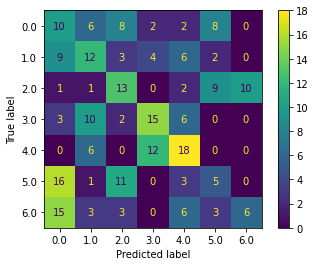

In [24]:
# Recording scores and viewing confusion matrix
train_score =  my_RBF_kernel_SVM.score(X_train_scaled, y_train)
test_score =  my_RBF_kernel_SVM.score(X_test_scaled, y_test)

y_pred = my_RBF_kernel_SVM.predict(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

display(plot_confusion_matrix(my_RBF_kernel_SVM, X_test_scaled, y_test))

prelimscores = prelimscores.append({'Model': 'Sigmoid Kernel SVM',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = 'Model', inplace=True, keep='last')
prelimscores

##### Bagged SVM

In [25]:
# Testing a bagged SVC
bagged_SVC = BaggingClassifier(SVC(C=70, max_iter = 10000),n_estimators=20, random_state=18)

bagged_SVC.fit(X_train_scaled, y_train)

print (f'Train score: {bagged_SVC.score(X_train_scaled, y_train)}')
print (f'Test score: {bagged_SVC.score(X_test_scaled, y_test)}')


Train score: 0.9965986394557823
Test score: 0.876984126984127


Model        Feature  Training Accuracy  Test Accuracy  \
0    Logistic Regression  40 Mean MFCCs           0.828231       0.742063   
1             Linear SVM  40 Mean MFCCs           0.799320       0.694444   
2         RBF Kernel SVM  40 Mean MFCCs           1.000000       0.884921   
3        Poly Kernel SVM  40 Mean MFCCs           0.994898       0.805556   
4     Sigmoid Kernel SVM  40 Mean MFCCs           0.358844       0.313492   
5  Bagged RBF Kernel SVM  40 Mean MFCCs           0.996599       0.876984   

   Precision    Recall        F1  
0   0.741228  0.742063  0.740304  
1   0.698235  0.694444  0.690156  
2   0.886538  0.884921  0.885090  
3   0.818079  0.805556  0.806077  
4   0.321602  0.313492  0.309187  
5   0.878114  0.876984  0.876270

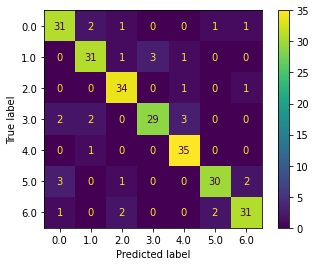

In [26]:
# Recording scores and viewing confusion matrix
train_score =  bagged_SVC.score(X_train_scaled, y_train)
test_score =  bagged_SVC.score(X_test_scaled, y_test)

y_pred = bagged_SVC.predict(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

display(plot_confusion_matrix(bagged_SVC, X_test_scaled, y_test))

prelimscores = prelimscores.append({'Model': 'Bagged RBF Kernel SVM',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = 'Model', inplace=True, keep='last')
prelimscores

In [27]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))
Top_SVM_Predict_Proba = bagged_SVC.predict_proba(X_test_scaled)

np.save("40 MFCCs Mean Bagged SVM Prediction Probabilities.npy",Top_SVM_Predict_Proba)

Definitely some value in bagging our top performing SVC model. 

#### Random Forest

We'll try a random forest classifier and optimize its parameters with GridSearchCV

In [28]:
# Using GridSearchCV to optimize parameters of a random forest
params = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30], 
          'max_features':[1,2,3,4,5,6,7,8,9,10,11,12,13]}

grid_search = GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid=params, cv = 5)
fitted_search = grid_search.fit(X_train_scaled, y_train)
fitted_search.best_params_
fitted_search.score(X_test_scaled, y_test)

0.8174603174603174

Model        Feature  Training Accuracy  Test Accuracy  \
0       Logistic Regression  40 Mean MFCCs           0.828231       0.742063   
1                Linear SVM  40 Mean MFCCs           0.799320       0.694444   
2            RBF Kernel SVM  40 Mean MFCCs           1.000000       0.884921   
3           Poly Kernel SVM  40 Mean MFCCs           0.994898       0.805556   
4        Sigmoid Kernel SVM  40 Mean MFCCs           0.358844       0.313492   
5     Bagged RBF Kernel SVM  40 Mean MFCCs           0.996599       0.876984   
6  Random Forest Classifier  40 Mean MFCCs           1.000000       0.817460   

   Precision    Recall        F1  
0   0.741228  0.742063  0.740304  
1   0.698235  0.694444  0.690156  
2   0.886538  0.884921  0.885090  
3   0.818079  0.805556  0.806077  
4   0.321602  0.313492  0.309187  
5   0.878114  0.876984  0.876270  
6   0.821464  0.817460  0.815880

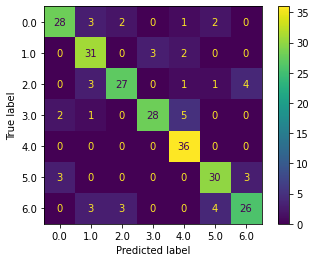

In [29]:
# Recording scores of optimized random forest
train_score =  fitted_search.score(X_train_scaled, y_train)
test_score =  fitted_search.score(X_test_scaled, y_test)

y_pred = fitted_search.predict(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

display(plot_confusion_matrix(fitted_search, X_test_scaled, y_test))

prelimscores = prelimscores.append({'Model': 'Random Forest Classifier',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = 'Model', inplace=True, keep='last')
prelimscores

In [30]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))
Top_RR_Predict_Proba = fitted_search.predict_proba(X_test_scaled)
np.save("40 MFCCs Random Forest Prediction Probabilities.npy",Top_RR_Predict_Proba)

#### Neural Networks

##### Preprocessing for Dense Neural Network

In [31]:
#Neural Network Preprocessing

#Loading mean MFCC dataframe

os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced_w_mfcc = pd.read_csv("Balanced Audio Data with 40 MFCCs.csv", index_col=False)
audiodata_balanced_w_mfcc

# Selecting X & y and splitting into train/test
X = audiodata_balanced_w_mfcc.iloc[:,6:]
y = audiodata_balanced_w_mfcc.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)

# Scaling and transforming
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Converting all arrays to float
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

#Checking that the data is in the appropriate format for Keras to use.
print(f'X_train shape: {X_train_scaled.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test_scaled.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_train range: {X_train_scaled.min()}-{X_train_scaled.max()}')
print(f'y_train range: {y_train.min()}-{y_train.max()}')
print(f'X_test range: {X_test_scaled.min()}-{X_test_scaled.max()}')
print(f'y_test range: {y_test.min()}-{y_test.max()}')
print(f'X_train type: {X_train_scaled.dtype}')
print(f'X_test type: {X_test_scaled.dtype}')
print(f'y_train type: {y_train.dtype}')
print(f'y_test type: {y_test.dtype}')

X_train shape: (588, 40)
y_train shape: (588,)
X_test shape: (252, 40)
y_test shape: (252,)
X_train range: -4.607614994049072-6.978975772857666
y_train range: 0.0-6.0
X_test range: -4.0974650382995605-6.177619457244873
y_test range: 0.0-6.0
X_train type: float32
X_test type: float32
y_train type: float32
y_test type: float32


##### Dense Neural Network

In [32]:
# Instantiating neural network architecture
model = Sequential()
model.add(Dense(512, activation='relu',input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               20992     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

In [33]:
model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [34]:
# # Uncomment this if you'd like to train the model yourself

# ESC = EarlyStopping(monitor = 'val_accuracy', restore_best_weights=True, patience=200)

# model.fit(X_train_scaled, y_train,
#               epochs = 1000,
#               verbose = 1, 
#           validation_data=(X_test_scaled, y_test),
#           callbacks=[ESC])

In [35]:
# Loading our pretrained model
# Comment this out if you're training the model yourself and want to test accuracy.
os.chdir(os.path.join(PATH,'Models'))
model = load_model('Mean 40 MFCCs Dense Neural Network')

In [36]:
# Basic dense neural network with mean MFCC
score = model.evaluate(X_test_scaled, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 0s 1ms/step - loss: 0.6391 - accuracy: 0.8889
Test loss: 0.6391456723213196
Test accuracy: 0.8888888955116272


In [37]:
# Recording scores and viewing confusion matrix
train_score = model.evaluate(X_train_scaled, y_train,verbose=0)[1]
test_score = model.evaluate(X_test_scaled, y_test,verbose=0)[1]

y_pred = model.predict_classes(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

labels=['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised']
labels = np.array(labels)

cf = confusion_matrix(y_test,y_pred)


prelimscores = prelimscores.append({'Model': 'Dense Neural Network',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = 'Model', inplace=True, keep='last')
display(prelimscores)
display(cf)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Model        Feature  Training Accuracy  Test Accuracy  \
0       Logistic Regression  40 Mean MFCCs           0.828231       0.742063   
1                Linear SVM  40 Mean MFCCs           0.799320       0.694444   
2            RBF Kernel SVM  40 Mean MFCCs           1.000000       0.884921   
3           Poly Kernel SVM  40 Mean MFCCs           0.994898       0.805556   
4        Sigmoid Kernel SVM  40 Mean MFCCs           0.358844       0.313492   
5     Bagged RBF Kernel SVM  40 Mean MFCCs           0.996599       0.876984   
6  Random Forest Classifier  40 Mean MFCCs           1.000000       0.817460   
7      Dense Neural Network  40 Mean MFCCs           0.998299       0.888889   

   Precision    Recall        F1  
0   0.741228  0.742063  0.740304  
1   0.698235  0.694444  0.690156  
2   0.886538  0.884921  0.885090  
3   0.818079  0.805556  0.806077  
4   0.321602  0.313492  0.309187  
5   0.878114  0.876984  0.876270  
6   0.821464  0.817460  0.815880  
7   0.892167  0.888889  0.889646

array([[31,  0,  2,  0,  0,  2,  1],
       [ 2, 33,  1,  0,  0,  0,  0],
       [ 0,  0, 32,  0,  1,  0,  3],
       [ 2,  1,  0, 32,  1,  0,  0],
       [ 0,  1,  0,  1, 34,  0,  0],
       [ 3,  0,  1,  0,  0, 30,  2],
       [ 1,  0,  2,  0,  0,  1, 32]])

In [38]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))

Dense_NN_40_Mean_MFFC_predict_proba = model.predict(X_test_scaled)

np.save("40 MFCCs Mean Dense Neural Net Prediction Probabilities.npy",Dense_NN_40_Mean_MFFC_predict_proba)

In [39]:
os.chdir('/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Models')
model.save("Mean 40 MFCCs Dense Neural Network")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Mean 40 MFCCs Dense Neural Network/assets


##### 1D CNN

In [40]:
# Preprocessing for 1D CNN
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [41]:
# Building a 1D CNN
model = Sequential()
model.add(Conv1D(128, 5,activation='relu',input_shape=(X_train_scaled.shape[1],1)))
model.add(MaxPooling1D(2))

model.add(Conv1D(512, 5,activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(2))

model.add(Conv1D(256, 3,activation='relu',))
model.add(MaxPooling1D(2))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(32, activation = 'relu'))

model.add(Dense(7, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 36, 128)           768       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 18, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14, 512)           328192    
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 512)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 512)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 256)            393472    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 256)           

In [42]:
model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [43]:
# # Uncomment this if you'd like to train the model yourself

# ESC = EarlyStopping(monitor = 'val_accuracy', restore_best_weights=True, patience=100)

# model.fit(X_train_scaled, y_train,
#               epochs = 1000,
#               verbose = 1,
#               validation_data=(X_test_scaled, y_test),
#           callbacks=[ESC])

In [44]:
# Comment this out if you're training the model yourself and want to test accuracy.
os.chdir(os.path.join(PATH,'Models'))
model = load_model("Mean 40 MFCCs CNN")

In [45]:
#1D CNN score on mean MFCC
score = model.evaluate(X_test_scaled, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 0s 4ms/step - loss: 0.6305 - accuracy: 0.8373
Test loss: 0.6304519772529602
Test accuracy: 0.8373016119003296


In [46]:
# Recording scores
train_score = model.evaluate(X_train_scaled, y_train,verbose=0)[1]
test_score = model.evaluate(X_test_scaled, y_test,verbose=0)[1]

y_pred = model.predict_classes(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

labels=['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised']
labels = np.array(labels)

cf = confusion_matrix(y_test,y_pred)


prelimscores = prelimscores.append({'Model': '1D CNN',
                                    'Feature': '40 Mean MFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = ('Model','Feature'), inplace=True, keep='last')
display(prelimscores)
display(cf)

Model        Feature  Training Accuracy  Test Accuracy  \
0       Logistic Regression  40 Mean MFCCs           0.828231       0.742063   
1                Linear SVM  40 Mean MFCCs           0.799320       0.694444   
2            RBF Kernel SVM  40 Mean MFCCs           1.000000       0.884921   
3           Poly Kernel SVM  40 Mean MFCCs           0.994898       0.805556   
4        Sigmoid Kernel SVM  40 Mean MFCCs           0.358844       0.313492   
5     Bagged RBF Kernel SVM  40 Mean MFCCs           0.996599       0.876984   
6  Random Forest Classifier  40 Mean MFCCs           1.000000       0.817460   
7      Dense Neural Network  40 Mean MFCCs           0.998299       0.888889   
8                    1D CNN  40 Mean MFCCs           1.000000       0.837302   

   Precision    Recall        F1  
0   0.741228  0.742063  0.740304  
1   0.698235  0.694444  0.690156  
2   0.886538  0.884921  0.885090  
3   0.818079  0.805556  0.806077  
4   0.321602  0.313492  0.309187  
5   0.878114  0.876984  0.876270  
6   0.821464  0.817460  0.815880  
7   0.892167  0.888889  0.889646  
8   0.842294  0.837302  0.836389

array([[29,  1,  2,  1,  0,  2,  1],
       [ 1, 32,  1,  1,  0,  0,  1],
       [ 0,  0, 26,  0,  1,  3,  6],
       [ 1,  3,  2, 27,  3,  0,  0],
       [ 0,  0,  1,  0, 35,  0,  0],
       [ 2,  0,  1,  0,  0, 29,  4],
       [ 1,  1,  0,  0,  0,  1, 33]])

In [47]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))
CNN_40_Mean_MFFC_predict_proba = model.predict(X_test_scaled)
np.save("40 MFCCs Mean CNN Prediction Probabilities.npy",CNN_40_Mean_MFFC_predict_proba)

In [48]:
os.chdir(os.path.join(PATH,'Models'))
model.save("Mean 40 MFCCs CNN")

INFO:tensorflow:Assets written to: Mean 40 MFCCs CNN/assets


Ok, well we've achieved roughly the same accuracy with both neural networks, and neither are have better results then our kernel SVM. We're going to move on from here and extract some more features.

## Part 2

### MFCC 2D CNN

In [49]:
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)
audiodata_balanced

Filename Dataset Sex Speaker  Duration  Emotion
0                h05.wav   SAVEE   M      KL      3.38        5
1               sa04.wav   SAVEE   M      KL      4.73        3
2                h11.wav   SAVEE   M      KL      5.53        5
3               sa10.wav   SAVEE   M      KL      4.15        3
4                d08.wav   SAVEE   M      KL      3.29        1
..                   ...     ...  ..     ...       ...      ...
835  YAF_tough_happy.wav    TESS   F     YAF      1.73        5
836      OAF_late_ps.wav    TESS   F     OAF      1.96        6
837       OAF_fat_ps.wav    TESS   F     OAF      1.98        6
838     OAF_life_sad.wav    TESS   F     OAF      2.56        3
839  OAF_check_angry.wav    TESS   F     OAF      1.65        0

[840 rows x 6 columns]

#### Creating Numpy Array of MFCCs

In [50]:
# This script will create an array consisting of a 2D array of 40 MFCCs over time for each audio file.
os.chdir(os.path.join(PATH,'Data Sets'))
start_time = time.time()
df = audiodata_balanced

N_mfcc = 40

hop_length = 512


# A function to help us access the file structure of TESS dataset
def emotion_reverse(emotion):
    
    x = str
    if emotion == 0:
        x = 'angry'
    if emotion == 1:
        x = 'disgust'
    if emotion == 2:
        x = 'fear'
    if emotion == 3:
        x = 'sad'
    if emotion == 4:
        x = 'neutral'
    if emotion == 5:
        x = 'happy'
    if emotion == 6:
        x = 'pleasant_surprised'
    return (x)

# Our dataframe will be sized according to the audio file with the longest duration. 
# All shorter files will be padded to match that size before having MFCCs extracted.

df = audiodata_balanced


max_length = df['Duration'].argmax()

filename = df.iloc[max_length]['Filename']
dataset = df.iloc[max_length]['Dataset']
speaker = df.iloc[max_length]['Speaker']
emotion = df.iloc[max_length]['Emotion']

if (dataset=='SAVEE'):
    y, sr = librosa.load(os.path.join(dataset, speaker, filename), sr = 22050)
elif(dataset=='TESS'):
    emotion = emotion_reverse(emotion)
    speaker_emotion = (f'{speaker}_{emotion}')
    y, sr = librosa.load(os.path.join(dataset, speaker_emotion, filename), sr = 22050)
    
max_length = len(y)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = 40, hop_length = hop_length)

# Creating our 3D array of 40 MFCCs over time.

MFCC_array = np.empty(shape=(len(df), mfccs.shape[0], mfccs.shape[1]), dtype = 'float32')
for n in range(0, len(df)):
    
    filename = df.iloc[n]['Filename']
    dataset = df.iloc[n]['Dataset']
    speaker = df.iloc[n]['Speaker']
    emotion = df.iloc[n]['Emotion']
    
    if (dataset=='SAVEE'):
        y, sr = librosa.load(os.path.join(dataset, speaker, filename), sr = 22050)
    elif(dataset=='TESS'):
        emotion = emotion_reverse(emotion)
        speaker_emotion = (f'{speaker}_{emotion}')
        y, sr = librosa.load(os.path.join(dataset, speaker_emotion, filename), sr = 22050)
        
    pad_length = max_length - len(y)
    y = np.pad(y,((0,pad_length)),'constant')
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = N_mfcc, hop_length = hop_length)
    
    MFCC_array[n] = mfccs

    print('\r',f'{n+1} arrays added',end='')
    
os.chdir(os.path.join(PATH,'DataFrames'))
np.save('40_MFCC_array.npy', MFCC_array)

 840 arrays added

#### Preprocessing

In [51]:
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)
MFCC_array = np.load('40_MFCC_array.npy')
print(f' Shape of dataframe: {MFCC_array.shape}')

 Shape of dataframe: (840, 40, 308)


In [52]:
# Selecting X & y and splitting into train/test
X = audiodata_balanced.iloc[:,:5]
y = audiodata_balanced.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)


#Train/test splitting our numpy array of MFCCs
MFCC_array_TRAIN = np.empty(shape=(len(X_train.index), MFCC_array.shape[1], MFCC_array.shape[2]))

for n in range(0,len(X_train.index)):
    
    i = X_train.index[n]
    MFCC_array_TRAIN[n]=MFCC_array[i]
    
MFCC_array_TEST = np.empty(shape=(len(X_test.index), MFCC_array.shape[1], MFCC_array.shape[2]))

for n in range(0,len(X_test.index)):
    
    i = X_test.index[n]
    MFCC_array_TEST[n]=MFCC_array[i]

X_train = MFCC_array_TRAIN
X_test = MFCC_array_TEST
    
# Reshaping our array for a 2D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print(f' X_train shape: {X_train.shape}')
print(f' X_test shape: {X_test.shape}')

 X_train shape: (588, 40, 308, 1)
 X_test shape: (252, 40, 308, 1)


#### 2D CNN

In [53]:
# Architecture for 2D CNN

model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu', input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(128,(6,6),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3), padding = 'same'))

model.add(Conv2D(256,(2),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,7), padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(16))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(7, activation='softmax'))
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 306, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 306, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 153, 32)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 19, 153, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 148, 128)      147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 148, 128)      512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 50, 128)       

In [54]:
model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimizers.Adam(0.002),
                  metrics = ['accuracy'])

In [55]:
# # Uncomment this if you'd like to train the model yourself

# ESC = EarlyStopping(monitor = 'val_accuracy', restore_best_weights=True, patience=30)

# model.fit(X_train_scaled, y_train,
#               epochs = 1000, 
#               batch_size=49,
#               verbose = 1,
#               validation_data=(X_test_scaled, y_test),
#           callbacks=[ESC])

In [56]:
# Comment this out if you're training the model yourself and want to test accuracy.
os.chdir(os.path.join(PATH,'Models'))
model = load_model("40 MFCC 2D CNN")

In [57]:
# 2D CNN With Total MFCC results
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 1s 110ms/step - loss: 0.5190 - accuracy: 0.8294
Test loss: 0.5189852118492126
Test accuracy: 0.829365074634552


In [58]:
# Recording scores
train_score = model.evaluate(X_train, y_train,verbose=0)[1]
test_score = model.evaluate(X_test, y_test,verbose=0)[1]

y_pred = model.predict_classes(X_test)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

labels=['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised']
labels = np.array(labels)

cf = confusion_matrix(y_test,y_pred)


prelimscores = prelimscores.append({'Model': '2D CNN',
                                    'Feature': '40 MMFCCs Over Time',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = 'Model', inplace=True, keep='last')
display(prelimscores)
display(cf)

Model              Feature  Training Accuracy  \
0       Logistic Regression        40 Mean MFCCs           0.828231   
1                Linear SVM        40 Mean MFCCs           0.799320   
2            RBF Kernel SVM        40 Mean MFCCs           1.000000   
3           Poly Kernel SVM        40 Mean MFCCs           0.994898   
4        Sigmoid Kernel SVM        40 Mean MFCCs           0.358844   
5     Bagged RBF Kernel SVM        40 Mean MFCCs           0.996599   
6  Random Forest Classifier        40 Mean MFCCs           1.000000   
7      Dense Neural Network        40 Mean MFCCs           0.998299   
8                    1D CNN        40 Mean MFCCs           1.000000   
9                    2D CNN  40 MMFCCs Over Time           0.998299   

   Test Accuracy  Precision    Recall        F1  
0       0.742063   0.741228  0.742063  0.740304  
1       0.694444   0.698235  0.694444  0.690156  
2       0.884921   0.886538  0.884921  0.885090  
3       0.805556   0.818079  0.805556  0.806077  
4       0.313492   0.321602  0.313492  0.309187  
5       0.876984   0.878114  0.876984  0.876270  
6       0.817460   0.821464  0.817460  0.815880  
7       0.888889   0.892167  0.888889  0.889646  
8       0.837302   0.842294  0.837302  0.836389  
9       0.829365   0.843677  0.829365  0.827864

array([[34,  0,  1,  0,  1,  0,  0],
       [ 2, 26,  1,  1,  5,  0,  1],
       [ 1,  0, 32,  1,  1,  0,  1],
       [ 3,  1,  1, 25,  6,  0,  0],
       [ 0,  0,  0,  0, 35,  0,  1],
       [ 1,  0,  1,  0,  0, 30,  4],
       [ 2,  0,  3,  0,  0,  4, 27]])

In [59]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))
CNN_40_MFFC_predict_proba = model.predict(X_test)
np.save("40 MFCCs 2DCNN Prediction Probabilities.npy",CNN_40_MFFC_predict_proba)

In [60]:
os.chdir(os.path.join(PATH,'Models'))
model.save("40 MFCC 2D CNN")

INFO:tensorflow:Assets written to: 40 MFCC 2D CNN/assets


### Raw Audio

#### Creating our DataFrame Via NP Array

In [61]:
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)
audiodata_balanced

Filename Dataset Sex Speaker  Duration  Emotion
0                h05.wav   SAVEE   M      KL      3.38        5
1               sa04.wav   SAVEE   M      KL      4.73        3
2                h11.wav   SAVEE   M      KL      5.53        5
3               sa10.wav   SAVEE   M      KL      4.15        3
4                d08.wav   SAVEE   M      KL      3.29        1
..                   ...     ...  ..     ...       ...      ...
835  YAF_tough_happy.wav    TESS   F     YAF      1.73        5
836      OAF_late_ps.wav    TESS   F     OAF      1.96        6
837       OAF_fat_ps.wav    TESS   F     OAF      1.98        6
838     OAF_life_sad.wav    TESS   F     OAF      2.56        3
839  OAF_check_angry.wav    TESS   F     OAF      1.65        0

[840 rows x 6 columns]

In [62]:
# This cell will create a data frame consisting of raw audio sampled at 11 kHz

os.chdir(os.path.join(PATH,'Data Sets'))

start_time = time.time()
df = audiodata_balanced

# Change this to change the sampling rate of audio.
s_r = 11000

# A function to help us access the file structure of TESS dataset
def emotion_reverse(emotion):
    
    x = str
    if emotion == 0:
        x = 'angry'
    if emotion == 1:
        x = 'disgust'
    if emotion == 2:
        x = 'fear'
    if emotion == 3:
        x = 'sad'
    if emotion == 4:
        x = 'neutral'
    if emotion == 5:
        x = 'happy'
    if emotion == 6:
        x = 'pleasant_surprised'
    return (x)

# Our dataframe will be sized according to the audio file with the longest duration. 
# All shorter files will be padded to match that size.

df = audiodata_balanced
max_length = df['Duration'].argmax()
filename = df.iloc[max_length]['Filename']
dataset = df.iloc[max_length]['Dataset']
speaker = df.iloc[max_length]['Speaker']
emotion = df.iloc[max_length]['Emotion']

if (dataset=='SAVEE'):
    y, sr = librosa.load(os.path.join(dataset, speaker, filename), sr = s_r)
elif(dataset=='TESS'):
    emotion = emotion_reverse(emotion)
    speaker_emotion = (f'{speaker}_{emotion}')
    y, sr = librosa.load(os.path.join(dataset, speaker_emotion, filename), sr = s_r)
    
max_length = len(y)

# Creating our array for raw audio, and iterating through our files to extract raw audio sampled at the sampling rate specified above.
Raw_Audio = np.empty(shape=(len(df), max_length), dtype = 'float32')

for n in range(0, len(df)):
    
    filename = df.iloc[n]['Filename']
    dataset = df.iloc[n]['Dataset']
    speaker = df.iloc[n]['Speaker']
    emotion = df.iloc[n]['Emotion']
    
    if (dataset=='SAVEE'):
        y, sr = librosa.load(os.path.join(dataset, speaker, filename), sr = s_r)
    elif(dataset=='TESS'):
        emotion = emotion_reverse(emotion)
        speaker_emotion = (f'{speaker}_{emotion}')
        y, sr = librosa.load(os.path.join(dataset, speaker_emotion, filename), sr = s_r)
        
    pad_length = max_length - len(y)
    y = np.pad(y,((0,pad_length)),'constant')
    
    Raw_Audio[n]=y
    
    
    print('\r',f'{n} files added',end='')
    
raw_audio_df = pd.DataFrame(Raw_Audio)
raw_audio_df = audiodata_balanced.join(raw_audio_df)
raw_audio_np = raw_audio_df.to_numpy()


 839 files added

In [63]:
os.chdir(os.path.join(PATH,'DataFrames'))
np.save('raw_audio_np.npy', raw_audio_np)

#### Preprocessing

In [64]:
os.chdir(os.path.join(PATH,'DataFrames'))
raw_audio_np = np.load('raw_audio_np.npy', allow_pickle=True)
raw_audio_df = pd.DataFrame(raw_audio_np)
raw_audio_df.head(10)

0      1     2     3     4     5            6           7      \
0   h05.wav  SAVEE     M    KL  3.38     5  0.000832211  0.00149924   
1  sa04.wav  SAVEE     M    KL  4.73     3  0.000965189   0.0017641   
2   h11.wav  SAVEE     M    KL  5.53     5   0.00336419  0.00596941   
3  sa10.wav  SAVEE     M    KL  4.15     3   0.00091811   0.0015671   
4   d08.wav  SAVEE     M    KL  3.29     1  0.000800967  0.00144275   
5   d09.wav  SAVEE     M    KL  3.87     1  0.000966482  0.00169078   
6  sa11.wav  SAVEE     M    KL  5.53     3   0.00351112  0.00614769   
7   h10.wav  SAVEE     M    KL  2.77     5  0.000905883  0.00159786   
8  sa05.wav  SAVEE     M    KL   4.3     3  0.000794086  0.00135566   
9   h04.wav  SAVEE     M    KL  2.69     5  0.000934297  0.00165646   

        8           9      ... 78523 78524 78525 78526 78527 78528 78529  \
0  0.00126183  0.00137868  ...     0     0     0     0     0     0     0   
1  0.00154292  0.00163406  ...     0     0     0     0     0     0     0   
2  0.00522398  0.00564609  ...     0     0     0     0     0     0     0   
3  0.00134119  0.00141341  ...     0     0     0     0     0     0     0   
4  0.00128943  0.00137163  ...     0     0     0     0     0     0     0   
5  0.00149761  0.00161123  ...     0     0     0     0     0     0     0   
6    0.005302  0.00574475  ...     0     0     0     0     0     0     0   
7  0.00141415  0.00148697  ...     0     0     0     0     0     0     0   
8  0.00116451   0.0012547  ...     0     0     0     0     0     0     0   
9  0.00149927  0.00160527  ...     0     0     0     0     0     0     0   

  78530 78531 78532  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0  
5     0     0     0  
6     0     0     0  
7     0     0     0  
8     0     0     0  
9     0     0     0  

[10 rows x 78533 columns]

In [65]:
# Selecting X & y and splitting into train/test
X = raw_audio_df.iloc[:,6:]
y = raw_audio_df.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)


X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

#Converting all arrays to float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f' X_train Shape: {X_train.shape}')
print(f' X_test Shape: {X_test.shape}')
print(f'X_train range: {X_train.min()}-{X_train.max()}')
print(f'X_test range: {X_test.min()}-{X_test.max()}')


 X_train Shape: (588, 78527, 1)
 X_test Shape: (252, 78527, 1)
X_train range: -1.2134182453155518-1.1184977293014526
X_test range: -1.1293245553970337-1.093063473701477


#### 1D CNN Model with Raw Audio

In [66]:
# Building a 1D CNN
model = Sequential()

model.add(Conv1D(32,(3), input_shape = (X_train.shape[1],1),kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model.add(Conv1D(64,(9),kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))

model.add(MaxPooling1D())

model.add(Dropout(0.1))
model.add(Conv1D(32,(9),kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model.add(MaxPooling1D(4))

model.add(Dropout(0.2))
model.add(Conv1D(64,(9),kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model.add(MaxPooling1D(4))
model.add(Dropout(0.3))


model.add(Conv1D(128,(9),kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu'))
model.add(MaxPooling1D(4))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(7, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 78525, 32)         128       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 78517, 64)         18496     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 39258, 64)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 39258, 64)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 39250, 32)         18464     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 9812, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 9812, 32)         

In [67]:
model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [68]:
# # Uncomment this if you'd like to train the model yourself

# ESC = EarlyStopping(monitor = 'val_accuracy',patience = 20, restore_best_weights=True)

# model.fit(X_train, y_train,
#               epochs = 1000,
#               verbose = 1,
#               validation_data=(X_test, y_test),
#           shuffle=True,
#          callbacks=ESC)

In [69]:
# Here we're going to load the final model that's already been trained on the augmented data, 
# comment out this cell if you'd like to see training results from unaugmented data and train with the cell above.

os.chdir(os.path.join(PATH,'Models'))
model = load_model('Raw Audio 1D CNN')

In [70]:
# 1D CNN With Raw Audio results
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 8s 954ms/step - loss: 6.4207 - accuracy: 0.4603
Test loss: 6.4207377433776855
Test accuracy: 0.460317462682724


In [71]:
# Recording Scores
train_score = model.evaluate(X_train, y_train,verbose=0)[1]
test_score = model.evaluate(X_test, y_test,verbose=0)[1]

y_pred = model.predict_classes(X_test)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

labels=['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised']
labels = np.array(labels)

cf = confusion_matrix(y_test,y_pred)


prelimscores = prelimscores.append({'Model': '1D CNN',
                                    'Feature': 'Raw Audio',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = ('Model', 'Feature'), inplace=True, keep='last')
display(prelimscores)
display(cf)

Model              Feature  Training Accuracy  \
0        Logistic Regression        40 Mean MFCCs           0.828231   
1                 Linear SVM        40 Mean MFCCs           0.799320   
2             RBF Kernel SVM        40 Mean MFCCs           1.000000   
3            Poly Kernel SVM        40 Mean MFCCs           0.994898   
4         Sigmoid Kernel SVM        40 Mean MFCCs           0.358844   
5      Bagged RBF Kernel SVM        40 Mean MFCCs           0.996599   
6   Random Forest Classifier        40 Mean MFCCs           1.000000   
7       Dense Neural Network        40 Mean MFCCs           0.998299   
8                     1D CNN        40 Mean MFCCs           1.000000   
9                     2D CNN  40 MMFCCs Over Time           0.998299   
10                    1D CNN            Raw Audio           0.926871   

    Test Accuracy  Precision    Recall        F1  
0        0.742063   0.741228  0.742063  0.740304  
1        0.694444   0.698235  0.694444  0.690156  
2        0.884921   0.886538  0.884921  0.885090  
3        0.805556   0.818079  0.805556  0.806077  
4        0.313492   0.321602  0.313492  0.309187  
5        0.876984   0.878114  0.876984  0.876270  
6        0.817460   0.821464  0.817460  0.815880  
7        0.888889   0.892167  0.888889  0.889646  
8        0.837302   0.842294  0.837302  0.836389  
9        0.829365   0.843677  0.829365  0.827864  
10       0.460317   0.489659  0.460317  0.451641

array([[18,  3,  9,  1,  3,  2,  0],
       [ 2, 15,  3,  4,  7,  3,  2],
       [ 5,  0, 17,  2,  5,  3,  4],
       [ 0,  4,  3, 13, 13,  1,  2],
       [ 0,  0,  2,  1, 30,  2,  1],
       [ 7,  0,  3,  1,  8, 14,  3],
       [ 2,  0, 10,  0,  7,  8,  9]])

In [72]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))
CNN_Raw_Audio_predict_proba = model.predict(X_test)

np.save("Raw Audio 1DCNN Prediction Probabilities.npy",CNN_Raw_Audio_predict_proba)

In [73]:
os.chdir(os.path.join(PATH,'Models'))
model.save("Raw Audio 1D CNN")

INFO:tensorflow:Assets written to: Raw Audio 1D CNN/assets


In [74]:
# Saving our train and test set in a new directory called 'Training Data'
if not os.path.exists(os.path.join(PATH,'Training Data')):
    os.makedirs(os.path.join(PATH,'Training Data'))

os.chdir(os.path.join(PATH,'Training Data'))
np.save('Raw Audio 1D CNN - X_train.npy', X_train)
np.save('Raw Audio 1D CNN - X_test.npy', X_test)
np.save('Raw Audio 1D CNN - y_train.npy', y_train)
np.save('Raw Audio 1D CNN - y_test.npy', y_test)


### Data Augmentation

With the number of features of our neural network and relative few number of samples our network is very prone to overfitting. We're going to address this by augmentating/resampling our data with various types of transformations including randomizing the padding of each sample, pitch transpositions, time stretching, chopping the audio in various ways, and noise injections.

In [75]:
os.chdir(os.path.join(PATH,'DataFrames'))
raw_audio_np = np.load('raw_audio_np.npy', allow_pickle=True)
raw_audio_df = pd.DataFrame(raw_audio_np)
raw_audio_df.head(10)

0      1     2     3     4     5            6           7      \
0   h05.wav  SAVEE     M    KL  3.38     5  0.000832211  0.00149924   
1  sa04.wav  SAVEE     M    KL  4.73     3  0.000965189   0.0017641   
2   h11.wav  SAVEE     M    KL  5.53     5   0.00336419  0.00596941   
3  sa10.wav  SAVEE     M    KL  4.15     3   0.00091811   0.0015671   
4   d08.wav  SAVEE     M    KL  3.29     1  0.000800967  0.00144275   
5   d09.wav  SAVEE     M    KL  3.87     1  0.000966482  0.00169078   
6  sa11.wav  SAVEE     M    KL  5.53     3   0.00351112  0.00614769   
7   h10.wav  SAVEE     M    KL  2.77     5  0.000905883  0.00159786   
8  sa05.wav  SAVEE     M    KL   4.3     3  0.000794086  0.00135566   
9   h04.wav  SAVEE     M    KL  2.69     5  0.000934297  0.00165646   

        8           9      ... 78523 78524 78525 78526 78527 78528 78529  \
0  0.00126183  0.00137868  ...     0     0     0     0     0     0     0   
1  0.00154292  0.00163406  ...     0     0     0     0     0     0     0   
2  0.00522398  0.00564609  ...     0     0     0     0     0     0     0   
3  0.00134119  0.00141341  ...     0     0     0     0     0     0     0   
4  0.00128943  0.00137163  ...     0     0     0     0     0     0     0   
5  0.00149761  0.00161123  ...     0     0     0     0     0     0     0   
6    0.005302  0.00574475  ...     0     0     0     0     0     0     0   
7  0.00141415  0.00148697  ...     0     0     0     0     0     0     0   
8  0.00116451   0.0012547  ...     0     0     0     0     0     0     0   
9  0.00149927  0.00160527  ...     0     0     0     0     0     0     0   

  78530 78531 78532  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0  
5     0     0     0  
6     0     0     0  
7     0     0     0  
8     0     0     0  
9     0     0     0  

[10 rows x 78533 columns]

In [76]:
# We'll only augment our train set and leave the test set as is
X = raw_audio_df.iloc[:,6:]
y = raw_audio_df.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)




train_agg = raw_audio_df.iloc[:,:6]
train_agg = train_agg.merge(X_train,how = 'right', left_index=True,right_index=True)

X = train_agg.iloc[:,6:]

X=pd.DataFrame(X)

In [77]:
# A sample of pre-transformed data
test = X.loc[327]
ipd.Audio(test, rate = 11000)

#### Adding noise

In [78]:
# From https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6
def manipulate(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    #augmented_data = augmented_data.astype(type(data))
    return augmented_data

In [79]:
# A function to add random amounts of noise to each file
noisy = np.empty(shape = (X.shape[0],X.shape[1]))

for i in range(0,X.shape[0]):

    noise_audio = manipulate(X.iloc[i], 0.005)
    noisy[i] = noise_audio
    
    print('\r',f'{i+1}/{X.shape[0]} done', end='')
    

labels = train_agg.iloc[:,:6].reset_index(drop=True)

raw_audio_augmented_df = pd.concat((labels, pd.DataFrame(noisy)), axis=1)    

raw_audio_augmented_df=raw_audio_augmented_df.T.reset_index(drop=True).T

raw_audio_augmented_df=train_agg.append(raw_audio_augmented_df, ignore_index=True)               


 588/588 done

In [81]:
# Sampling the transformed data
test = raw_audio_augmented_df.iloc[1111,6:]
ipd.Audio(test, rate=s_r)

#### Random padding

In [82]:
# This function will randomize the padding of silence around each file.
padding = np.empty((X.shape[0],X.shape[1]))

for i in range(0, X.shape[0]):
    
    trimmed = X.iloc[i]
    trimmed = np.trim_zeros(trimmed, 'b')

    to_pad = X.shape[1]-len(trimmed)

    rand_pad = np.random.randint(0,to_pad)

    back_pad = to_pad - rand_pad

    new = np.pad(trimmed,(rand_pad, back_pad))
    
    padding[i] = new
    
    
    print('\r',f'{i+1}/{X.shape[0]} done', end='')
    
labels = train_agg.iloc[:,:6].reset_index(drop=True)
    
temp = pd.concat((labels, pd.DataFrame(padding)), axis=1)    

temp=temp.T.reset_index(drop=True).T

raw_audio_augmented_df=raw_audio_augmented_df.append(temp, ignore_index=True)

raw_audio_augmented_df
    
    

 588/588 done

0      1     2     3     4     5            6      \
0                n19.wav  SAVEE     M    JK  3.43     4    0.0245255   
1               sa02.wav  SAVEE     M    KL  2.71     3  0.000760664   
2               su11.wav  SAVEE     M    KL  2.01     6   0.00332422   
3               su03.wav  SAVEE     M    JE  2.91     6   0.00946853   
4        OAF_far_sad.wav   TESS     F   OAF  2.66     3 -1.46548e-05   
...                  ...    ...   ...   ...   ...   ...          ...   
1759             n22.wav  SAVEE     M    JK  3.11     4            0   
1760             d10.wav  SAVEE     M    JK  4.22     1            0   
1761  OAF_such_angry.wav   TESS     F   OAF  1.67     0            0   
1762             a11.wav  SAVEE     M    KL  2.41     0            0   
1763             a02.wav  SAVEE     M    JK  3.65     0            0   

            7            8            9      ... 78523 78524 78525 78526  \
0       0.0433004    0.0375684    0.0404392  ...     0     0     0     0   
1      0.00135792   0.00124155   0.00137014  ...     0     0     0     0   
2      0.00581218   0.00504536   0.00549822  ...     0     0     0     0   
3       0.0167303    0.0142864    0.0150583  ...     0     0     0     0   
4     4.98678e-05  0.000134485  8.66057e-05  ...     0     0     0     0   
...           ...          ...          ...  ...   ...   ...   ...   ...   
1759            0            0            0  ...     0     0     0     0   
1760            0            0            0  ...     0     0     0     0   
1761            0            0            0  ...     0     0     0     0   
1762            0            0            0  ...     0     0     0     0   
1763            0            0            0  ...     0     0     0     0   

     78527 78528 78529 78530 78531 78532  
0        0     0     0     0     0     0  
1        0     0     0     0     0     0  
2        0     0     0     0     0     0  
3        0     0     0     0     0     0  
4        0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...  
1759     0     0     0     0     0     0  
1760     0     0     0     0     0     0  
1761     0     0     0     0     0     0  
1762     0     0     0     0     0     0  
1763     0     0     0     0     0     0  

[1764 rows x 78533 columns]

In [83]:
# Sampling our transformed data
test = raw_audio_augmented_df.iloc[1182,6:]
ipd.Audio(test, rate=s_r)

#### Pitch Transpositions

In [84]:
# This function will pitch shift each audio file by a random amount
pitch_shifted = np.empty((X.shape[0], X.shape[1]))

for i in range(0,X.shape[0]):
    
    audio = X.iloc[i]
    audio = audio.to_numpy(dtype='float32')
    to_shift = np.random.uniform(0.3,2.1)
    shift = 11000*to_shift
    y = librosa.core.resample(audio,11000,shift, fix=False)
    
    
    
    if (len(y) < X.shape[1]):
    
        to_pad = X.shape[1] - len(y)
    
        new = np.pad(y,(0, to_pad))
        
    elif (len(y) > X.shape[1]):
        chopped = np.split(y, [X.shape[1]])
        new = chopped[0]
        
    else:
        new=y
    
    pitch_shifted[i]=new
    
    print('\r',f'{i}/{X.shape[0]} done', end='')
    
labels = train_agg.iloc[:,:6].reset_index(drop=True)
    
temp = pd.concat((labels, pd.DataFrame(pitch_shifted)), axis=1)    

temp=temp.T.reset_index(drop=True).T

raw_audio_augmented_df=raw_audio_augmented_df.append(temp, ignore_index=True)

raw_audio_augmented_df

 587/588 done

0      1     2     3     4     5            6      \
0                n19.wav  SAVEE     M    JK  3.43     4    0.0245255   
1               sa02.wav  SAVEE     M    KL  2.71     3  0.000760664   
2               su11.wav  SAVEE     M    KL  2.01     6   0.00332422   
3               su03.wav  SAVEE     M    JE  2.91     6   0.00946853   
4        OAF_far_sad.wav   TESS     F   OAF  2.66     3 -1.46548e-05   
...                  ...    ...   ...   ...   ...   ...          ...   
2347             n22.wav  SAVEE     M    JK  3.11     4    0.0243038   
2348             d10.wav  SAVEE     M    JK  4.22     1    0.0315961   
2349  OAF_such_angry.wav   TESS     F   OAF  1.67     0  9.85884e-06   
2350             a11.wav  SAVEE     M    KL  2.41     0   0.00326978   
2351             a02.wav  SAVEE     M    JK  3.65     0    0.0227302   

            7            8            9      ... 78523 78524 78525 78526  \
0       0.0433004    0.0375684    0.0404392  ...     0     0     0     0   
1      0.00135792   0.00124155   0.00137014  ...     0     0     0     0   
2      0.00581218   0.00504536   0.00549822  ...     0     0     0     0   
3       0.0167303    0.0142864    0.0150583  ...     0     0     0     0   
4     4.98678e-05  0.000134485  8.66057e-05  ...     0     0     0     0   
...           ...          ...          ...  ...   ...   ...   ...   ...   
2347    0.0380122    0.0423922    0.0395885  ...     0     0     0     0   
2348    0.0541001    0.0519789    0.0498718  ...     0     0     0     0   
2349  4.36343e-05  5.59217e-05  3.26737e-05  ...     0     0     0     0   
2350   0.00584025   0.00506981   0.00543755  ...     0     0     0     0   
2351    0.0438354    0.0383508     0.041498  ...     0     0     0     0   

     78527 78528 78529 78530 78531 78532  
0        0     0     0     0     0     0  
1        0     0     0     0     0     0  
2        0     0     0     0     0     0  
3        0     0     0     0     0     0  
4        0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...  
2347     0     0     0     0     0     0  
2348     0     0     0     0     0     0  
2349     0     0     0     0     0     0  
2350     0     0     0     0     0     0  
2351     0     0     0     0     0     0  

[2352 rows x 78533 columns]

In [85]:
# Sampling the pitch shifted data
test = raw_audio_augmented_df.iloc[2306,6:]
ipd.Audio(test, rate=s_r)

#### Time stretching

In [86]:
# This function will time stretch each audio file by a random amount
time_stretched = np.empty((X.shape[0], X.shape[1]))

for i in range(0,X.shape[0]):

    
    audio = X.iloc[i]
    audio = audio.to_numpy(dtype='float32')
    to_stretch = np.random.randint(100,1000)

    D = librosa.core.stft(audio,hop_length=to_stretch)
    y = librosa.core.istft(D)
    
    if (len(y) < X.shape[1]):
    
        to_pad = X.shape[1] - len(y)
    
        new = np.pad(y,(0, to_pad))
        
    elif (len(y) > X.shape[1]):
        chopped = np.split(y, [X.shape[1]])
        new = chopped[0]
        
    else:
        new=y
        
    time_stretched[i]=new
    
    print('\r',f'{i+1}/{X.shape[0]} done', end='')
    
labels = train_agg.iloc[:,:6].reset_index(drop=True)
    
temp = pd.concat((labels, pd.DataFrame(time_stretched)), axis=1)    

temp=temp.T.reset_index(drop=True).T

raw_audio_augmented_df=raw_audio_augmented_df.append(temp, ignore_index=True)

raw_audio_augmented_df


 588/588 done

0      1     2     3     4     5            6      \
0                n19.wav  SAVEE     M    JK  3.43     4    0.0245255   
1               sa02.wav  SAVEE     M    KL  2.71     3  0.000760664   
2               su11.wav  SAVEE     M    KL  2.01     6   0.00332422   
3               su03.wav  SAVEE     M    JE  2.91     6   0.00946853   
4        OAF_far_sad.wav   TESS     F   OAF  2.66     3 -1.46548e-05   
...                  ...    ...   ...   ...   ...   ...          ...   
2935             n22.wav  SAVEE     M    JK  3.11     4    0.0273896   
2936             d10.wav  SAVEE     M    JK  4.22     1    0.0352296   
2937  OAF_such_angry.wav   TESS     F   OAF  1.67     0 -0.000309091   
2938             a11.wav  SAVEE     M    KL  2.41     0   0.00379885   
2939             a02.wav  SAVEE     M    JK  3.65     0    0.0281413   

            7            8            9      ... 78523 78524 78525 78526  \
0       0.0433004    0.0375684    0.0404392  ...     0     0     0     0   
1      0.00135792   0.00124155   0.00137014  ...     0     0     0     0   
2      0.00581218   0.00504536   0.00549822  ...     0     0     0     0   
3       0.0167303    0.0142864    0.0150583  ...     0     0     0     0   
4     4.98678e-05  0.000134485  8.66057e-05  ...     0     0     0     0   
...           ...          ...          ...  ...   ...   ...   ...   ...   
2935    0.0421753    0.0375724    0.0399537  ...     0     0     0     0   
2936    0.0547486    0.0494476    0.0528562  ...     0     0     0     0   
2937 -0.000507433 -0.000561698 -0.000365326  ...     0     0     0     0   
2938   0.00584752   0.00517632   0.00549643  ...     0     0     0     0   
2939    0.0433502    0.0387321    0.0414346  ...     0     0     0     0   

     78527 78528 78529 78530 78531 78532  
0        0     0     0     0     0     0  
1        0     0     0     0     0     0  
2        0     0     0     0     0     0  
3        0     0     0     0     0     0  
4        0     0     0     0     0     0  
...    ...   ...   ...   ...   ...   ...  
2935     0     0     0     0     0     0  
2936     0     0     0     0     0     0  
2937     0     0     0     0     0     0  
2938     0     0     0     0     0     0  
2939     0     0     0     0     0     0  

[2940 rows x 78533 columns]

In [87]:
# Saving our augmented data
raw_audio_augmented_np = raw_audio_augmented_df.to_numpy()
os.chdir(os.path.join(PATH,'DataFrames'))
np.save('raw_audio_augmented_np.npy', raw_audio_augmented_np)

### CNN model 2nd Iteration of Training

In [88]:
os.chdir(os.path.join(PATH,'Models'))
model = load_model('Raw Audio 1D CNN - Trained on augmented data')

os.chdir(os.path.join(PATH,'DataFrames'))
raw_audio_np = np.load('raw_audio_np.npy', allow_pickle=True)
raw_audio_df = pd.DataFrame(raw_audio_np)
raw_audio_df.head(10)


0      1     2     3     4     5            6           7      \
0   h05.wav  SAVEE     M    KL  3.38     5  0.000832211  0.00149924   
1  sa04.wav  SAVEE     M    KL  4.73     3  0.000965189   0.0017641   
2   h11.wav  SAVEE     M    KL  5.53     5   0.00336419  0.00596941   
3  sa10.wav  SAVEE     M    KL  4.15     3   0.00091811   0.0015671   
4   d08.wav  SAVEE     M    KL  3.29     1  0.000800967  0.00144275   
5   d09.wav  SAVEE     M    KL  3.87     1  0.000966482  0.00169078   
6  sa11.wav  SAVEE     M    KL  5.53     3   0.00351112  0.00614769   
7   h10.wav  SAVEE     M    KL  2.77     5  0.000905883  0.00159786   
8  sa05.wav  SAVEE     M    KL   4.3     3  0.000794086  0.00135566   
9   h04.wav  SAVEE     M    KL  2.69     5  0.000934297  0.00165646   

        8           9      ... 78523 78524 78525 78526 78527 78528 78529  \
0  0.00126183  0.00137868  ...     0     0     0     0     0     0     0   
1  0.00154292  0.00163406  ...     0     0     0     0     0     0     0   
2  0.00522398  0.00564609  ...     0     0     0     0     0     0     0   
3  0.00134119  0.00141341  ...     0     0     0     0     0     0     0   
4  0.00128943  0.00137163  ...     0     0     0     0     0     0     0   
5  0.00149761  0.00161123  ...     0     0     0     0     0     0     0   
6    0.005302  0.00574475  ...     0     0     0     0     0     0     0   
7  0.00141415  0.00148697  ...     0     0     0     0     0     0     0   
8  0.00116451   0.0012547  ...     0     0     0     0     0     0     0   
9  0.00149927  0.00160527  ...     0     0     0     0     0     0     0   

  78530 78531 78532  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0  
5     0     0     0  
6     0     0     0  
7     0     0     0  
8     0     0     0  
9     0     0     0  

[10 rows x 78533 columns]

In [89]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 78525, 32)         128       
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 78517, 64)         18496     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 39258, 64)         0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 39258, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 39250, 32)         18464     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 9812, 32)          0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 9812, 32)        

In [90]:
# Selecting X & y and splitting into train/test
X_train = raw_audio_augmented_df.iloc[:,6:]
y_train = raw_audio_augmented_df.iloc[:,5]

X_train = X_train.to_numpy()

if (type(X_test)!= np.ndarray ):
    X_test = X_test.to_numpy()

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

(2940, 78527, 1)
(252, 78527, 1)


In [91]:
os.chdir(os.path.join(PATH,'Training Data'))
np.save('X_train_augmented.npy', X_train)
np.save('y_train_augmented.npy', y_train)

In [92]:
# # Uncomment this if you'd like to train the model yourself
# ESC = EarlyStopping(patience = 20, restore_best_weights=True)

# model.fit(X_train, y_train,
#               epochs = 1000,
#               verbose = 1,
#               validation_data=(X_test, y_test),
#           shuffle=True,
#          callbacks=ESC)

In [93]:
# 1D CNN With Raw Audio results
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 9s 1s/step - loss: 2.2365 - accuracy: 0.6508
Test loss: 2.236487865447998
Test accuracy: 0.6507936716079712


In [ ]:
# Recording Scores
train_score = model.evaluate(X_train, y_train,verbose=0)[1]
test_score = model.evaluate(X_test, y_test,verbose=0)[1]

y_pred = model.predict_classes(X_test)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

labels=['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised']
labels = np.array(labels)

cf = confusion_matrix(y_test,y_pred)


prelimscores = prelimscores.append({'Model': '1D CNN',
                                    'Feature': 'Raw Audio Augmented',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = ('Model', 'Feature'), inplace=True, keep='last')
display(prelimscores)
display(cf)

In [94]:
os.chdir(os.path.join(PATH,'Models'))
model.save('Raw Audio 1D CNN - Trained on augmented data')

INFO:tensorflow:Assets written to: Raw Audio 1D CNN - Trained on augmented data/assets


### RNNs

After simply not being able to get a recurrent neural network to start training with so many audio samples, we performed a number of experiments to reformat the data so that an RNN could being training. These techniques allowed us to start training, but the RNNs were not able to capture any meaningful information from the data. The processes from these experiments are outlined below.

In [95]:
os.chdir(os.path.join(PATH,'Training Data'))

X_train = np.load('X_train_augmented.npy')

y_train = np.load('y_train_augmented.npy')

X_test = np.load('Raw Audio 1D CNN - X_test.npy')

y_test = np.load('Raw Audio 1D CNN - y_test.npy')


#### Test 1: Chopping up our augmented data to reduce features and increase number of samples.

In [96]:
# This function will chop each audio file into 10 pieces and re add each piece to the end of the data, while also extending y_train and y_test to match.
X_train_chopped = np.resize(X_train,(2940,78500))
X_test_chopped = np.resize(X_test, (X_test.shape[0],78500))

X_train_chopped = pd.DataFrame(X_train_chopped)
X_test_chopped = pd.DataFrame(X_test_chopped)

new_size = X_train_chopped.shape[1]/10
X_train_new = pd.DataFrame()

count = 0

for i in range(0,10):
    
    
    X_temp = X_train_chopped.iloc[:,int(i*new_size):int((i+1)*new_size)]
    X_temp = X_temp.T.reset_index(drop=True).T
    
    X_train_new = X_train_new.append(X_temp)
    
    count+=1
    print('\r', f'{count} done', end='')
    
new_size = X_test_chopped.shape[1]/10
X_test_new = pd.DataFrame()

for i in range(0,10):
    
    X_temp = X_test_chopped.iloc[:,int(i*new_size):int((i+1)*new_size)]
    X_temp = X_temp.T.reset_index(drop=True).T
    
    X_test_new = X_test_new.append(X_temp)
    
    count+=1
    print('\r', f'{count} done', end='')
    
y_temp = y_train
y_safety = y_train
for i in range(1,10):
    y_temp = np.append(y_temp,y_train)

y_train = y_temp

y_temp = y_test
y_safety = y_test
for i in range(1,10):
    y_temp = np.append(y_temp,y_test)

y_test = y_temp

X_train_new = X_train_new.to_numpy()
X_test_new = X_test_new.to_numpy()
X_train_new = X_train_new.reshape((X_train_new.shape[0], X_train_new.shape[1],1))
X_test_new = X_test_new.reshape((X_test_new.shape[0], X_test_new.shape[1],1))

 20 done

In [97]:
# RNN model architecture
RNN_model = Sequential()

RNN_model.add(LSTM(64, input_shape=(X_train_new.shape[1:]), return_sequences=True))

RNN_model.add(Dropout(0.1))
RNN_model.add(BatchNormalization())

RNN_model.add(LSTM(256))

RNN_model.add(Dropout(0.15))
RNN_model.add(BatchNormalization())

RNN_model.add(Dense(16, activation='relu'))
RNN_model.add(Dropout(0.2))

RNN_model.add(Dense(7, activation='softmax'))

RNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7850, 64)          16896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 7850, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7850, 64)          256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 16)               

In [98]:
RNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [99]:
# # Uncomment this if you'd like to train the model yourself
# ESC = EarlyStopping(monitor = 'val_accuracy',patience = 20, restore_best_weights=True)

# RNN_model.fit(X_train_new, y_train,
#               epochs = 18,
#               verbose = 1,
#               validation_data=(X_test_new, y_test),
#           shuffle=True,
#          callbacks=ESC)

Nope! That wasn't working. Let's try something else...


#### Test 2: Downscaling audio to reduce features and to eliminate padded silence

In [100]:
os.chdir(os.path.join(PATH,'DataFrames'))
raw_audio_np = np.load('raw_audio_np.npy', allow_pickle=True)
raw_audio_df = pd.DataFrame(raw_audio_np)
raw_audio_df.head(10)

0      1     2     3     4     5            6           7      \
0   h05.wav  SAVEE     M    KL  3.38     5  0.000832211  0.00149924   
1  sa04.wav  SAVEE     M    KL  4.73     3  0.000965189   0.0017641   
2   h11.wav  SAVEE     M    KL  5.53     5   0.00336419  0.00596941   
3  sa10.wav  SAVEE     M    KL  4.15     3   0.00091811   0.0015671   
4   d08.wav  SAVEE     M    KL  3.29     1  0.000800967  0.00144275   
5   d09.wav  SAVEE     M    KL  3.87     1  0.000966482  0.00169078   
6  sa11.wav  SAVEE     M    KL  5.53     3   0.00351112  0.00614769   
7   h10.wav  SAVEE     M    KL  2.77     5  0.000905883  0.00159786   
8  sa05.wav  SAVEE     M    KL   4.3     3  0.000794086  0.00135566   
9   h04.wav  SAVEE     M    KL  2.69     5  0.000934297  0.00165646   

        8           9      ... 78523 78524 78525 78526 78527 78528 78529  \
0  0.00126183  0.00137868  ...     0     0     0     0     0     0     0   
1  0.00154292  0.00163406  ...     0     0     0     0     0     0     0   
2  0.00522398  0.00564609  ...     0     0     0     0     0     0     0   
3  0.00134119  0.00141341  ...     0     0     0     0     0     0     0   
4  0.00128943  0.00137163  ...     0     0     0     0     0     0     0   
5  0.00149761  0.00161123  ...     0     0     0     0     0     0     0   
6    0.005302  0.00574475  ...     0     0     0     0     0     0     0   
7  0.00141415  0.00148697  ...     0     0     0     0     0     0     0   
8  0.00116451   0.0012547  ...     0     0     0     0     0     0     0   
9  0.00149927  0.00160527  ...     0     0     0     0     0     0     0   

  78530 78531 78532  
0     0     0     0  
1     0     0     0  
2     0     0     0  
3     0     0     0  
4     0     0     0  
5     0     0     0  
6     0     0     0  
7     0     0     0  
8     0     0     0  
9     0     0     0  

[10 rows x 78533 columns]

In [101]:
# This function will pitch shift each file so that they match the length of the audio file that's shortest in duration.
temp = raw_audio_df.iloc[:,6:]
temp = temp.to_numpy()
min_size = []
for i in range(0, temp.shape[0]):
    size = np.trim_zeros(temp[i],trim='b').shape[0]
    
    min_size.append(size)

min(min_size)

downscaled = np.empty((temp.shape[0], 14600))

for i in range(0,temp.shape[0]):

    audio = temp[i]
    audio=audio.astype('float32')
    audio = np.trim_zeros(audio,trim='b')
    size = audio.shape[0]

    sr = int((14600*11000)/size)


    y = librosa.core.resample(audio,11000,sr, fix=True)

    y = np.resize(y,14600)

    downscaled[i]=y
    
    print('\r',f'{i+1}/{temp.shape[0]} done', end='')

 840/840 done

In [102]:
# Splitting into train and test
downscaled_df = pd.DataFrame(downscaled)

temp = raw_audio_df.iloc[:,:6]
downscaled_df = pd.concat((temp, downscaled_df),axis = 1)

X = downscaled_df.iloc[:,6:]
y = downscaled_df.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)

In [103]:
# This function will chop each audio file into 10 pieces and re add each piece to the end of the data, while also extending y_train and y_test to match.
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

new_size = X_train.shape[1]/10
X_train_new = pd.DataFrame()
count=0

for i in range(0,10):
    
    X_temp = X_train.iloc[:,int(i*new_size):int((i+1)*new_size)]
    X_temp = X_temp.T.reset_index(drop=True).T
    
    X_train_new = X_train_new.append(X_temp)
    
    count+=1
    print('\r', f'{count} done', end='')  
    
new_size = X_test.shape[1]/10
X_test_new = pd.DataFrame()


for i in range(0,10):
    
    X_temp = X_test.iloc[:,int(i*new_size):int((i+1)*new_size)]
    X_temp = X_temp.T.reset_index(drop=True).T
    
    X_test_new = X_test_new.append(X_temp)
    
    count+=1
    print('\r', f'{count} done', end='') 

y_temp = y_train
y_safety = y_train
for i in range(1,10):
    y_temp = np.append(y_temp,y_train)
    
    count+=1
    print('\r', f'{count} done', end='') 
    
y_train = y_temp
    
y_temp = y_test
y_safety = y_test
for i in range(1,10):
    y_temp = np.append(y_temp,y_test)
    
    count+=1
    print('\r', f'{count} done', end='') 
    
y_test = y_temp

X_train_new = X_train_new.to_numpy()
X_test_new = X_test_new.to_numpy()
X_train_new = X_train_new.reshape(X_train_new.shape[0],X_train_new.shape[1],1)
X_test_new = X_test_new.reshape(X_test_new.shape[0],X_test_new.shape[1],1)

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
X_train_new = X_train_new.astype('float32')
X_test_new = X_test_new.astype('float32')

 38 done

In [104]:
# RNN model architecture
RNN_model = Sequential()

RNN_model.add(LSTM(64, input_shape=(X_train_new.shape[1:]), return_sequences=True))

RNN_model.add(Dropout(0.1))
RNN_model.add(BatchNormalization())

RNN_model.add(LSTM(256))

RNN_model.add(Dropout(0.15))
RNN_model.add(BatchNormalization())

RNN_model.add(Dense(16, activation='relu'))
RNN_model.add(Dropout(0.2))

RNN_model.add(Dense(7, activation='softmax'))

RNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1460, 64)          16896     
_________________________________________________________________
dropout_17 (Dropout)         (None, 1460, 64)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1460, 64)          256       
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_13 (Dense)             (None, 16)               

In [105]:
RNN_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [106]:
# # Uncomment this if you'd like to train the model yourself
# ESC = EarlyStopping(monitor = 'val_accuracy',patience = 20, restore_best_weights=True)

# RNN_model.fit(X_train_new, y_train,
#               epochs = 18,
#               verbose = 1,
#               validation_data=(X_test_new, y_test),
#           shuffle=True,
#          callbacks=ESC)

In [107]:
os.chdir(os.path.join(PATH,'Training Data'))

np.save('X_train_downscaled_chopped.npy', X_train_new)

np.save('X_test_downscaled_chopped.npy', X_test_new)

np.save('y_train_downscaled_chopped.npy', y_train)

np.save('y_test_downscaled_chopped.npy', y_test)


#### Test 3: Using the mean of 40 MFCCs Over Time

In [108]:
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)
MFCC_array = np.load('40_MFCC_array.npy')
print(f' Shape of dataframe: {MFCC_array.shape}')

 Shape of dataframe: (840, 40, 308)


In [109]:
# Selecting X & y and splitting into train/test
X = audiodata_balanced.iloc[:,:5]
y = audiodata_balanced.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)


#Train/test splitting our numpy array of MFCCs
MFCC_array_TRAIN = np.empty(shape=(len(X_train.index), MFCC_array.shape[1], MFCC_array.shape[2]))

for n in range(0,len(X_train.index)):
    
    i = X_train.index[n]
    MFCC_array_TRAIN[n]=MFCC_array[i]
    
MFCC_array_TEST = np.empty(shape=(len(X_test.index), MFCC_array.shape[1], MFCC_array.shape[2]))

for n in range(0,len(X_test.index)):
    
    i = X_test.index[n]
    MFCC_array_TEST[n]=MFCC_array[i]

X_train = MFCC_array_TRAIN
X_test = MFCC_array_TEST
    
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

X_train_time = X_train.mean(axis=1)
X_test_time = X_test.mean(axis=1)

X_train_time = X_train_time.reshape(X_train_time.shape[0], X_train_time.shape[1], 1)
X_test_time = X_test_time.reshape(X_test_time.shape[0], X_test_time.shape[1], 1)

In [110]:
# RNN model architecture
RNN_model = Sequential()

RNN_model.add(LSTM(64, input_shape=(X_train_time.shape[1:]), return_sequences=True))

RNN_model.add(Dropout(0.1))
RNN_model.add(BatchNormalization())

RNN_model.add(LSTM(256))

RNN_model.add(Dropout(0.15))
RNN_model.add(BatchNormalization())

RNN_model.add(Dense(16, activation='relu'))
RNN_model.add(Dropout(0.2))

RNN_model.add(Dense(7, activation='softmax'))

RNN_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 308, 64)           16896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 308, 64)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 308, 64)           256       
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_15 (Dense)             (None, 16)               

In [111]:
sgd = optimizers.SGD(lr=0.1, decay=0.0, momentum=0.2, nesterov=True, clipnorm=2.0)

# Compile model
RNN_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy']
)

In [112]:
# # Uncomment this if you'd like to train the model yourself
# ESC = EarlyStopping(monitor = 'val_accuracy',patience = 20, restore_best_weights=True)

# RNN_model2.fit(X_train_time, y_train,
#               epochs = 18,
#               verbose = 1,
#               validation_data=(X_test_time, y_test),
#           shuffle=True,
#          callbacks=ESC)

#### Test 4: Tree Embedding MFCCs to create a fixed length vocabulary for an RNN to train on

In [113]:
# Reshaping MFCCs to prepare for tree embedding
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], X_test.shape[2])

X_train.shape

(588, 40, 308)

In [114]:
# Random tree embedding MFCCs
X_train_embedding = pd.DataFrame()
temp = pd.DataFrame(X_train[0])
X_train_embedding = X_train_embedding.append(temp)

for i in range(1,X_train.shape[0]):
    
    temp = pd.DataFrame(X_train[i])
    X_train_embedding = pd.concat((X_train_embedding,temp),axis=1)
    X_train_embedding
    
    print('\r', f'{i} arrays added', end='')

random_trees = RandomTreesEmbedding(n_estimators=200, random_state=11, max_depth=3)
random_trees.fit(X_train_embedding.T)

tree_test = random_trees.transform(X_test[0].T)

TREE_array = np.empty(shape=(X_train.shape[0], tree_test.shape[0], tree_test.shape[1]), dtype = 'float32')

for i in range(0,X_train.shape[0]):

    tree_test = random_trees.transform(X_train[i].T)
    tree_test = tree_test.todense()
    
    TREE_array[i]=tree_test

    print('\r', f'{i} arrays emdedded', end='')
    
TREE_test_array = np.empty(shape=(X_test.shape[0], tree_test.shape[0], tree_test.shape[1]), dtype = 'float32')

for i in range(0,X_test.shape[0]):

    tree_test = random_trees.transform(X_test[i].T)
    tree_test = tree_test.todense()
    
    TREE_test_array[i]=tree_test

    print('\r', f'{i} arrays emdedded', end='')

pd.DataFrame(TREE_array[0])  

 251 arrays emdedded

0     1     2     3     4     5     6     7     8     9     ...  1543  \
0     1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
303   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
304   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
305   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
306   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
307   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

     1544  1545  1546  1547  1548  1549  1550  1551  1552  
0     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
1     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
2     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
3     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
4     0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...  
303   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
304   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
305   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
306   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  
307   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0  

[308 rows x 1553 columns]

In [115]:
# RNN model architecture
RNN_model = Sequential()

RNN_model.add(LSTM(64, input_shape=(TREE_array.shape[1:]), return_sequences=True))

RNN_model.add(Dropout(0.1))
RNN_model.add(BatchNormalization())

RNN_model.add(LSTM(256))

RNN_model.add(Dropout(0.15))
RNN_model.add(BatchNormalization())

RNN_model.add(Dense(16, activation='relu'))
RNN_model.add(Dropout(0.2))

RNN_model.add(Dense(7, activation='softmax'))

RNN_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 308, 64)           414208    
_________________________________________________________________
dropout_23 (Dropout)         (None, 308, 64)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 308, 64)           256       
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dense_17 (Dense)             (None, 16)               

In [116]:
sgd = optimizers.SGD(lr=0.1, decay=0.0, momentum=0.0, nesterov=False, clipnorm=2.0)

# Compile model
RNN_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy']
)

In [117]:
# # Uncomment this if you'd like to train the model yourself
# ESC = EarlyStopping(monitor = 'val_accuracy',patience = 20, restore_best_weights=True)

# RNN_model2.fit(TREE_array, y_train,
#               epochs = 18,
#               verbose = 1,
#               validation_data=(TREE_test_array, y_test),
#           shuffle=True,
#          callbacks=ESC)

## Part 3

### GFCCs

#### GFCC Extraction Function

In [118]:
# This function will extract GFCCs from an audio file.

import numpy as np
import scipy
import scipy.signal
import scipy.fftpack

from librosa import util
from librosa import filters
#from ..util.exceptions import ParameterError

from librosa.core.time_frequency import fft_frequencies
from librosa.core.audio import zero_crossings, to_mono
from librosa.core.spectrum import power_to_db, _spectrogram
from librosa.core.constantq import cqt, hybrid_cqt
from librosa.core.pitch import estimate_tuning
from spafe.fbanks.gammatone_fbanks import gammatone_filter_banks

def gfcc_test(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs):


    if S is None:
        S = power_to_db(gammaspectrogram(y=y, sr=sr, **kwargs))

    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_mfcc]

    if lifter > 0:
        M *= 1 + (lifter / 2) * np.sin(np.pi * np.arange(1, 1 + n_mfcc, dtype=M.dtype) / lifter)[:, np.newaxis]
        return M
    elif lifter == 0:
        return M
    else:
        raise ParameterError('GFCC lifter={} must be a non-negative number'.format(lifter))

        
        
def gammaspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512,
                   win_length=None, window='hann', center=True, pad_mode='reflect',
                   power=2.0, **kwargs):


    S, n_fft = _spectrogram(y=y, S=S, n_fft=n_fft, hop_length=hop_length, power=power,
                            win_length=win_length, window=window, center=center,
                            pad_mode=pad_mode)


    gamma_basis = gammatone_filter_banks(fs=sr,nfft=n_fft,nfilts=128)

    return np.dot(gamma_basis, S)

#### Extracting Mean GFCCs

In [119]:
# This cell will build a dataframe with 40 mean GFCCs per file
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)

start_time = time.time()
GFCC_df = pd.DataFrame()
os.chdir(os.path.join(PATH,'Data Sets'))

def emotion_reverse(emotion):
    
    x = str
    if emotion == 0:
        x = 'angry'
    if emotion == 1:
        x = 'disgust'
    if emotion == 2:
        x = 'fear'
    if emotion == 3:
        x = 'sad'
    if emotion == 4:
        x = 'neutral'
    if emotion == 5:
        x = 'happy'
    if emotion == 6:
        x = 'pleasant_surprised'
    return (x)

for n in range(0,audiodata_balanced.shape[0]):
    
    filename = audiodata_balanced.iloc[n]['Filename']
    dataset = audiodata_balanced.iloc[n]['Dataset']
    speaker = audiodata_balanced.iloc[n]['Speaker']
    emotion = audiodata_balanced.iloc[n]['Emotion']
    
    if (dataset=='SAVEE'):
        y, sr = librosa.load(os.path.join(dataset, speaker, filename), sr = 41000)
    elif(dataset=='TESS'):
        emotion = emotion_reverse(emotion)
        speaker_emotion = (f'{speaker}_{emotion}')
        y, sr = librosa.load(os.path.join(dataset, speaker_emotion, filename), sr = 41000)
    
    gfcc_temp = gfcc_test(y=y, sr=sr, n_mfcc = 40, hop_length = 128)
    gfcc_temp = pd.Series(np.mean(gfcc_temp, axis=1))
    GFCC_df = GFCC_df.append(gfcc_temp, ignore_index=True)
    
    print('\r',f'{n+1}/{(audiodata_balanced.shape[0])} completed', end='')
    

audiodata_balanced_w_gfcc = pd.concat((audiodata_balanced, GFCC_df), ignore_index=True, axis=1)

print(f'Time to run: {time.time()-start_time}')

audiodata_balanced_w_gfcc.head(20)

os.chdir(os.path.join(PATH,'DataFrames'))

audiodata_balanced_w_gfcc.to_csv("Balanced Audio Data with 40 mean GFCCs.csv", index=False)



 840/840 completedTime to run: 112.63088202476501


#### Split into train/test set and scaling

In [120]:
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced_w_gfcc = pd.read_csv("Balanced Audio Data with 40 mean GFCCs.csv", index_col=False)
audiodata_balanced_w_gfcc

0      1  2    3     4  5           6          7  \
0                h05.wav  SAVEE  M   KL  3.38  5 -183.158146  68.339192   
1               sa04.wav  SAVEE  M   KL  4.73  3 -221.226845  77.327393   
2                h11.wav  SAVEE  M   KL  5.53  5 -147.864106  75.404642   
3               sa10.wav  SAVEE  M   KL  4.15  3 -236.471343  72.760758   
4                d08.wav  SAVEE  M   KL  3.29  1 -205.851061  78.053458   
..                   ...    ... ..  ...   ... ..         ...        ...   
835  YAF_tough_happy.wav   TESS  F  YAF  1.73  5  -15.143101  -4.655920   
836      OAF_late_ps.wav   TESS  F  OAF  1.96  6  -30.534656  45.232905   
837       OAF_fat_ps.wav   TESS  F  OAF  1.98  6 -120.573347  41.672444   
838     OAF_life_sad.wav   TESS  F  OAF  2.56  3 -114.152154  57.876885   
839  OAF_check_angry.wav   TESS  F  OAF  1.65  0  -26.290178  24.366405   

             8          9  ...        36        37        38        39  \
0    31.404625   4.350487  ... -2.228377 -0.219280 -1.964760  0.812831   
1    43.150954   3.801551  ... -3.547227 -1.429501 -2.852245  0.664793   
2    35.650959   0.170786  ... -2.904186 -1.129389 -2.536918  0.784598   
3    40.358937   7.772557  ... -3.009701 -1.388702 -3.251968  0.428593   
4    41.465328  -2.684655  ... -3.731850 -1.593435 -2.894428  0.513016   
..         ...        ...  ...       ...       ...       ...       ...   
835 -29.707993  -5.775906  ... -0.950754 -0.754689 -0.858125  0.563697   
836  -5.168251 -14.104773  ... -1.517480  0.032172 -2.559941 -0.419760   
837   3.320414  -3.423905  ... -1.380132 -0.682804 -2.831430 -0.100197   
838  21.517287  -2.070023  ... -2.502859  0.220062 -2.311666  0.214562   
839 -19.491521  -4.216290  ... -1.522985  0.474736 -1.106309  0.230675   

           40        41        42        43        44        45  
0   -2.007484  0.201631 -1.411502 -0.548924 -0.986277 -0.155011  
1   -2.053693  0.627292 -0.896826 -0.205743 -0.910789 -0.130045  
2   -2.349201  0.491206 -0.895490 -0.379380 -0.889682  0.104397  
3   -2.374962  0.316667 -0.958078 -0.171729 -0.794399  0.086306  
4   -2.381020  0.763118 -0.669096 -0.164168 -0.739948  0.055649  
..        ...       ...       ...       ...       ...       ...  
835 -0.173728  0.015240 -0.860091 -0.536434 -0.318392 -0.031819  
836 -1.787750  0.082428 -0.915094  0.259675 -0.120135 -0.224830  
837 -1.135867  0.442747 -0.895285 -0.558663 -0.668846 -0.120945  
838 -1.425549  0.297561 -1.184458 -0.032488 -0.815997 -0.092283  
839 -0.965443  0.172136 -0.824504 -0.161061 -0.567618 -0.400816  

[840 rows x 46 columns]

In [121]:
# Selecting X & y and splitting into train/test
X = audiodata_balanced_w_gfcc.iloc[:,6:]
y = audiodata_balanced_w_gfcc.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)

# Scaling and transforming
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

#### Kernel SVM

In [122]:
# Testing a kernel SVC with the GFCCs
from sklearn.svm import SVC
my_RBF_kernel_SVM = SVC(C=70, max_iter = 10000, probability=True)

my_RBF_kernel_SVM.fit(X_train_scaled, y_train)

print (f'Train score: {my_RBF_kernel_SVM.score(X_train_scaled, y_train)}')
print (f'Test score: {my_RBF_kernel_SVM.score(X_test_scaled, y_test)}')

Train score: 1.0
Test score: 0.8253968253968254


In [123]:
# Recording scores
train_score = my_RBF_kernel_SVM.score(X_train_scaled, y_train)
test_score = my_RBF_kernel_SVM.score(X_test_scaled, y_test)

y_pred = my_RBF_kernel_SVM.predict(X_test_scaled)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

labels=['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised']
labels = np.array(labels)

cf = confusion_matrix(y_test,y_pred)


prelimscores = prelimscores.append({'Model': 'RBF Kernel SVM',
                                    'Feature': '40 Mean GFCCs',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = ('Model','Feature'), inplace=True, keep='last')
display(prelimscores)
display(cf)

Model              Feature  Training Accuracy  \
0        Logistic Regression        40 Mean MFCCs           0.828231   
1                 Linear SVM        40 Mean MFCCs           0.799320   
2             RBF Kernel SVM        40 Mean MFCCs           1.000000   
3            Poly Kernel SVM        40 Mean MFCCs           0.994898   
4         Sigmoid Kernel SVM        40 Mean MFCCs           0.358844   
5      Bagged RBF Kernel SVM        40 Mean MFCCs           0.996599   
6   Random Forest Classifier        40 Mean MFCCs           1.000000   
7       Dense Neural Network        40 Mean MFCCs           0.998299   
8                     1D CNN        40 Mean MFCCs           1.000000   
9                     2D CNN  40 MMFCCs Over Time           0.998299   
10                    1D CNN            Raw Audio           0.926871   
11            RBF Kernel SVM        40 Mean GFCCs           1.000000   

    Test Accuracy  Precision    Recall        F1  
0        0.742063   0.741228  0.742063  0.740304  
1        0.694444   0.698235  0.694444  0.690156  
2        0.884921   0.886538  0.884921  0.885090  
3        0.805556   0.818079  0.805556  0.806077  
4        0.313492   0.321602  0.313492  0.309187  
5        0.876984   0.878114  0.876984  0.876270  
6        0.817460   0.821464  0.817460  0.815880  
7        0.888889   0.892167  0.888889  0.889646  
8        0.837302   0.842294  0.837302  0.836389  
9        0.829365   0.843677  0.829365  0.827864  
10       0.460317   0.489659  0.460317  0.451641  
11       0.825397   0.833378  0.825397  0.824484

array([[33,  1,  1,  0,  0,  0,  1],
       [ 1, 30,  1,  0,  2,  2,  0],
       [ 0,  0, 30,  0,  0,  1,  5],
       [ 2,  2,  2, 25,  4,  0,  1],
       [ 0,  1,  1,  1, 33,  0,  0],
       [ 4,  0,  3,  0,  0, 26,  3],
       [ 0,  0,  2,  0,  0,  3, 31]])

In [124]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))

SVM_gfcc_kernel_predict_proba = my_RBF_kernel_SVM.predict_proba(X_test_scaled)

np.save("40 Mean GFCC Kernel SVM Prediction Probabilities.npy",SVM_gfcc_kernel_predict_proba)

#### Dense Neural Network

In [125]:
#Neural Network Preprocessing

#Loading mean MFCC dataframe
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced_w_gfcc = pd.read_csv("Balanced Audio Data with 40 mean GFCCs.csv", index_col=False)
audiodata_balanced_w_gfcc

# Selecting X & y and splitting into train/test
X = audiodata_balanced_w_gfcc.iloc[:,6:]
y = audiodata_balanced_w_gfcc.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)

# Scaling and transforming
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Converting all arrays to float
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

#Checking that the data is in the appropriate format for Keras to use.
print(f'X_train shape: {X_train_scaled.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test_scaled.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_train range: {X_train_scaled.min()}-{X_train_scaled.max()}')
print(f'y_train range: {y_train.min()}-{y_train.max()}')
print(f'X_test range: {X_test_scaled.min()}-{X_test_scaled.max()}')
print(f'y_test range: {y_test.min()}-{y_test.max()}')
print(f'X_train type: {X_train_scaled.dtype}')
print(f'X_test type: {X_test_scaled.dtype}')
print(f'y_train type: {y_train.dtype}')
print(f'y_test type: {y_test.dtype}')

X_train shape: (588, 40)
y_train shape: (588,)
X_test shape: (252, 40)
y_test shape: (252,)
X_train range: -4.247110366821289-4.350104808807373
y_train range: 0.0-6.0
X_test range: -3.9438629150390625-3.835312843322754
y_test range: 0.0-6.0
X_train type: float32
X_test type: float32
y_train type: float32
y_test type: float32


In [126]:
# Dense neural net model architecture
model = Sequential()
model.add(Dense(512, activation='relu',input_shape=(X_train_scaled.shape[1],)))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               20992     
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)               

In [127]:
model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [128]:
# Comment this out if you're training the model yourself and want to test accuracy.
os.chdir(os.path.join(PATH,'Models'))
model = load_model('Mean 40 GFCCs Dense Neural Network')

In [129]:
# # Uncomment this if you'd like to train the model yourself
# ESC = EarlyStopping(monitor = 'val_accuracy', restore_best_weights=True, patience=200)

# model.fit(X_train_scaled, y_train,
#               epochs = 1000,
#               verbose = 1, 
#           validation_data=(X_test_scaled, y_test),
#           callbacks=[ESC])

In [130]:
# Basic dense neural network with mean MFCC
score = model.evaluate(X_test_scaled, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

8/8 [==============================] - 0s 1ms/step - loss: 1.3250 - accuracy: 0.8690
Test loss: 1.3249613046646118
Test accuracy: 0.8690476417541504


In [131]:
os.chdir(os.path.join(PATH,'Models'))
model.save("Mean 40 GFCCs Dense Neural Network")

INFO:tensorflow:Assets written to: Mean 40 GFCCs Dense Neural Network/assets


#### Preprocessing for 2D CNN

In [132]:
os.chdir(os.path.join(PATH,'DataFrames'))
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)
audiodata_balanced

Filename Dataset Sex Speaker  Duration  Emotion
0                h05.wav   SAVEE   M      KL      3.38        5
1               sa04.wav   SAVEE   M      KL      4.73        3
2                h11.wav   SAVEE   M      KL      5.53        5
3               sa10.wav   SAVEE   M      KL      4.15        3
4                d08.wav   SAVEE   M      KL      3.29        1
..                   ...     ...  ..     ...       ...      ...
835  YAF_tough_happy.wav    TESS   F     YAF      1.73        5
836      OAF_late_ps.wav    TESS   F     OAF      1.96        6
837       OAF_fat_ps.wav    TESS   F     OAF      1.98        6
838     OAF_life_sad.wav    TESS   F     OAF      2.56        3
839  OAF_check_angry.wav    TESS   F     OAF      1.65        0

[840 rows x 6 columns]

In [133]:
# This will create a 3D array consisting of the full length of 40 GFCCs per file
os.chdir(os.path.join(PATH,'Data Sets'))
start_time = time.time()
df = audiodata_balanced

hop_length = 512

def emotion_reverse(emotion):
    
    x = str
    if emotion == 0:
        x = 'angry'
    if emotion == 1:
        x = 'disgust'
    if emotion == 2:
        x = 'fear'
    if emotion == 3:
        x = 'sad'
    if emotion == 4:
        x = 'neutral'
    if emotion == 5:
        x = 'happy'
    if emotion == 6:
        x = 'pleasant_surprised'
    return (x)

# Our dataframe will be sized according to the audio file with the longest duration. 
# All shorter files will be padded to match that size before having MFCCs extracted.

df = audiodata_balanced


max_length = df['Duration'].argmax()

filename = df.iloc[max_length]['Filename']
dataset = df.iloc[max_length]['Dataset']
speaker = df.iloc[max_length]['Speaker']
emotion = df.iloc[max_length]['Emotion']

if (dataset=='SAVEE'):
    y, sr = librosa.load(os.path.join(dataset, speaker, filename), sr = 22050)
elif(dataset=='TESS'):
    emotion = emotion_reverse(emotion)
    speaker_emotion = (f'{speaker}_{emotion}')
    y, sr = librosa.load(os.path.join(dataset, speaker_emotion, filename), sr = 22050)

    
max_length = len(y)
    

gfccs = gfcc_test(y, sr = sr, n_mfcc=40)


# Creating our 3D array of 40 GFCCs over time.
GFCC_array = np.empty(shape=(len(df), gfccs.shape[0], gfccs.shape[1]), dtype = 'float32')

for n in range(0, len(df)):
    
    filename = df.iloc[n]['Filename']
    dataset = df.iloc[n]['Dataset']
    speaker = df.iloc[n]['Speaker']
    emotion = df.iloc[n]['Emotion']
    
    if (dataset=='SAVEE'):
        
        y, sr = librosa.load(os.path.join(dataset, speaker, filename), sr = 22050)

    elif(dataset=='TESS'):
        emotion = emotion_reverse(emotion)
        speaker_emotion = (f'{speaker}_{emotion}')
        
        y, sr = librosa.load(os.path.join(dataset, speaker_emotion, filename), sr = 22050)
        
    pad_length = max_length - len(y)
    y = np.pad(y,((0,pad_length)),'constant')
   

    gfccs = gfcc_test(y=y, sr=sr, n_mfcc=40)
    
    GFCC_array[n] = gfccs

    print('\r',f'{n+1} arrays added',end='')
    
os.chdir(os.path.join(PATH,'DataFrames'))
np.save('40_GFCC_array.npy', GFCC_array)

 840 arrays added

In [134]:
os.chdir(os.path.join(PATH,'DataFrames'))
GFCC_array = np.load('40_GFCC_array.npy')
audiodata_balanced = pd.read_csv("Balanced Audio Data.csv", index_col = False)

In [135]:
# Selecting X & y and splitting into train/test
X = audiodata_balanced.iloc[:,:5]
y = audiodata_balanced.iloc[:,5]

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.3, 
                                                    random_state = 18, 
                                                    stratify=y)

count=0
#Train/test splitting our numpy array of MFCCs
GFCC_array_TRAIN = np.empty(shape=(len(X_train.index), GFCC_array.shape[1], GFCC_array.shape[2]))

for n in range(0,len(X_train.index)):
    
    i = X_train.index[n]
    GFCC_array_TRAIN[n]=GFCC_array[i]
    
    count+=1
    print('\r', f'{count} arrays added', end='')
    
GFCC_array_TEST = np.empty(shape=(len(X_test.index), GFCC_array.shape[1], GFCC_array.shape[2]))

for n in range(0,len(X_test.index)):
    
    i = X_test.index[n]
    GFCC_array_TEST[n]=GFCC_array[i]
    
    count+=1
    print('\r', f'{count} arrays added', end='')

X_train = GFCC_array_TRAIN
X_test = GFCC_array_TEST
    
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print(f'X_train shape: {X_train.shape}')
print(f' X_test shape: {X_test.shape}')

 840 arrays addedX_train shape: (588, 40, 308, 1)
 X_test shape: (252, 40, 308, 1)


#### 2D CNN

In [136]:
# 2D CNN architecture
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu', input_shape=(X_train.shape[1],X_train.shape[2],1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.1))
model.add(Conv2D(128,(6,6),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,3), padding = 'same'))
model.add(Conv2D(256,(2),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3,7), padding = 'same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))
model.add(Dense(7, activation='softmax'))
model.summary() 


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 38, 306, 32)       320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 38, 306, 32)       128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 19, 153, 32)       0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 19, 153, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 148, 128)      147584    
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 148, 128)      512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 50, 128)       

In [137]:
model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimizers.Adam(0.002),
                  metrics = ['accuracy'])

In [138]:
# # Uncomment this if you'd like to train the model yourself

# ESC = EarlyStopping(monitor = 'val_accuracy', restore_best_weights=True, patience=30)

# model.fit(X_train, y_train,
#               epochs = 1000, 
#               batch_size=49,
#               verbose = 1,
#               validation_data=(X_test, y_test),
#           callbacks=[ESC])

In [139]:
os.chdir(os.path.join(PATH,'Models'))
model = load_model("40 GFCC 2DCNN")

In [140]:
# 2D CNN With Total MFCC results .3
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])


8/8 [==============================] - 1s 103ms/step - loss: 0.6343 - accuracy: 0.8254
Test loss: 0.6343187093734741
Test accuracy: 0.8253968358039856


In [141]:
# Recording scores
train_score = model.evaluate(X_train, y_train,verbose=0)[1]
test_score = model.evaluate(X_test, y_test,verbose=0)[1]

y_pred = model.predict_classes(X_test)
scores = precision_recall_fscore_support(y_test,y_pred, average='macro')
precision = scores[0]
recall = scores[1]
F1 = scores[2]

labels=['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised']
labels = np.array(labels)

cf = confusion_matrix(y_test,y_pred)


prelimscores = prelimscores.append({'Model': '2D CNN',
                                    'Feature': '40 GFCCs Over Time',
                                   'Training Accuracy': train_score,
                                   'Test Accuracy':test_score,
                                   'Precision': precision,
                                   'Recall': recall,
                                   'F1': F1}, 
                                   ignore_index=True)

prelimscores.drop_duplicates(subset = ('Model', 'Feature'), inplace=True, keep='last')
display(prelimscores)
display(cf)

Model              Feature  Training Accuracy  \
0        Logistic Regression        40 Mean MFCCs           0.828231   
1                 Linear SVM        40 Mean MFCCs           0.799320   
2             RBF Kernel SVM        40 Mean MFCCs           1.000000   
3            Poly Kernel SVM        40 Mean MFCCs           0.994898   
4         Sigmoid Kernel SVM        40 Mean MFCCs           0.358844   
5      Bagged RBF Kernel SVM        40 Mean MFCCs           0.996599   
6   Random Forest Classifier        40 Mean MFCCs           1.000000   
7       Dense Neural Network        40 Mean MFCCs           0.998299   
8                     1D CNN        40 Mean MFCCs           1.000000   
9                     2D CNN  40 MMFCCs Over Time           0.998299   
10                    1D CNN            Raw Audio           0.926871   
11            RBF Kernel SVM        40 Mean GFCCs           1.000000   
12                    2D CNN   40 GFCCs Over Time           1.000000   

    Test Accuracy  Precision    Recall        F1  
0        0.742063   0.741228  0.742063  0.740304  
1        0.694444   0.698235  0.694444  0.690156  
2        0.884921   0.886538  0.884921  0.885090  
3        0.805556   0.818079  0.805556  0.806077  
4        0.313492   0.321602  0.313492  0.309187  
5        0.876984   0.878114  0.876984  0.876270  
6        0.817460   0.821464  0.817460  0.815880  
7        0.888889   0.892167  0.888889  0.889646  
8        0.837302   0.842294  0.837302  0.836389  
9        0.829365   0.843677  0.829365  0.827864  
10       0.460317   0.489659  0.460317  0.451641  
11       0.825397   0.833378  0.825397  0.824484  
12       0.825397   0.847382  0.825397  0.825561

array([[29,  1,  0,  0,  2,  2,  2],
       [ 2, 28,  1,  0,  5,  0,  0],
       [ 1,  1, 31,  0,  1,  0,  2],
       [ 2,  1,  0, 23, 10,  0,  0],
       [ 0,  0,  0,  0, 36,  0,  0],
       [ 2,  0,  0,  0,  0, 31,  3],
       [ 0,  3,  1,  0,  0,  2, 30]])

In [142]:
# Saving predictions
os.chdir(os.path.join(PATH,'Predictions'))
cnn2d_gfcc_predict_proba = model.predict(X_test)
np.save("40 GFCC 2D CNN Prediction Probabilities.npy",cnn2d_gfcc_predict_proba)

In [143]:
os.chdir(os.path.join(PATH,'Models'))
model.save("40 GFCC 2DCNN")

INFO:tensorflow:Assets written to: 40 GFCC 2DCNN/assets


### Combining Predictions

In [144]:
# This will run through every possible combination of prediction probabilites to see which combination of models has the top final accuracy, and it will tell us which models those are.
import itertools

os.chdir(os.path.join(PATH,'Predictions'))

if (type(y_test)!= np.ndarray ):
    y_test = y_test.to_numpy()

predictions_list = []
with os.scandir(os.path.join(PATH,'Predictions')) as entries:
    for entry in entries:
        if entry.name != ('.DS_Store'):
            predictions_list.append(entry.name)

Prediction_Combos_df = pd.DataFrame(columns=predictions_list)
Prediction_Combos_df.insert(len(predictions_list),'Score',0)

row=0

for L in range(0, len(predictions_list)+1):
    for subset in itertools.combinations(predictions_list, L):
        #print(subset)
        if len(subset)>0:
            for i in range(len(subset)):
                Prediction_Combos_df.loc[row,subset[i]] = 1
        
            predictions = np.empty((len(subset), np.load(predictions_list[0]).shape[0],np.load(predictions_list[0]).shape[1]))
            for i in range(len(subset)):
                predictions[i]=np.load(subset[i])


            MVP = predictions[0]
            for i in range(1,predictions.shape[0]):
                MVP = MVP*predictions[i]
            y_pred = np.argmax(MVP, axis=1)
    #y_test = y_test.to_numpy()
            x=0
            for i in range(0,len(y_pred)):
                if (y_pred[i]==y_test[i]):
                    x+=1
        if len(subset) !=0:
            Prediction_Combos_df.loc[row,'Score'] = (x/len(y_pred))
        
        row+=1
        
top_score=Prediction_Combos_df.iloc[Prediction_Combos_df['Score'].argmax(),:]['Score']

print(f'Highest accuracy score: {round(top_score*100,2)}%')

best_models = []
for i in range(len(Prediction_Combos_df.iloc[Prediction_Combos_df['Score'].argmax(),:])-1):
    if Prediction_Combos_df.iloc[Prediction_Combos_df['Score'].argmax(),:][i]==1:
        best_models.append(Prediction_Combos_df.columns[i][:-29])

print(f'Best Models: {best_models}')

Highest accuracy score: 92.06%
Best Models: ['40 MFCCs 2DCNN', '40 MFCCs Mean Kernel SVM', '40 MFCCs Mean Dense Neural Net', '40 MFCCs Random Forest', '40 Mean GFCC Kernel SVM']


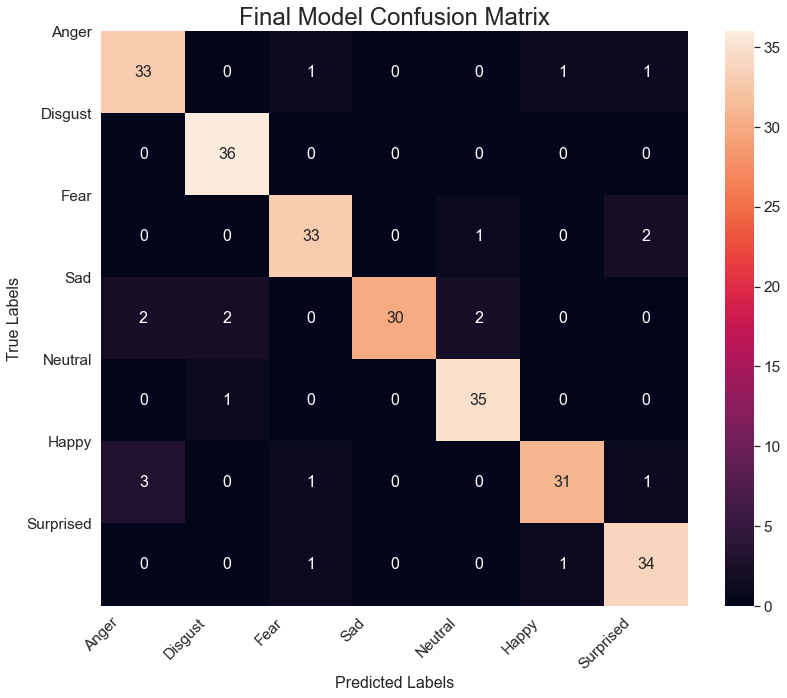

In [145]:
# Viewing the confusion matrix for our final combined model
os.chdir(os.path.join(PATH,'Predictions'))
predictions = np.empty((len(best_models), np.load((f'{best_models[0]} Prediction Probabilities.npy')).shape[0],np.load((f'{best_models[0]} Prediction Probabilities.npy')).shape[1]))
for i in range(len(best_models)):
    predictions[i]=np.load((f'{best_models[i]} Prediction Probabilities.npy'))

MVP = predictions[0]
for i in range(1,predictions.shape[0]):
    MVP = MVP*predictions[i]
y_pred = np.argmax(MVP, axis=1)

cm = confusion_matrix(y_test,y_pred)

df_cm = pd.DataFrame(cm)
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xticks(ticks = [0,1,2,3,4,5,6], labels =['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised'], rotation=45)
plt.yticks(ticks = [0,1,2,3,4,5,6], labels =['Anger', 'Disgust', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprised'],rotation=0)
plt.ylabel('True Labels', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=16)
plt.title('Final Model Confusion Matrix', fontsize=24)
plt.tight_layout()

os.chdir(os.path.join(PATH,'Presentation Materials'))    
plt.savefig('Confusion Matrix.png')

plt.show()


## Presentation Materials and Summary

In [146]:
# This is the final dataframe with scores of every model we tested.
prelimscores['Model and Feature'] = prelimscores[['Model', 'Feature']].agg('-'.join, axis=1)
prelimscores = prelimscores.sort_values('Test Accuracy', ascending=True)

os.chdir(os.path.join(PATH,'Presentation Materials'))
prelimscores.to_csv('prelimscoresdf.csv', index=False)

In [147]:
os.chdir(os.path.join(PATH,'Presentation Materials'))
prelimscores = pd.read_csv('prelimscoresdf.csv', index_col=False)
prelimscores

Model              Feature  Training Accuracy  \
0         Sigmoid Kernel SVM        40 Mean MFCCs           0.358844   
1                     1D CNN            Raw Audio           0.926871   
2                 Linear SVM        40 Mean MFCCs           0.799320   
3        Logistic Regression        40 Mean MFCCs           0.828231   
4            Poly Kernel SVM        40 Mean MFCCs           0.994898   
5   Random Forest Classifier        40 Mean MFCCs           1.000000   
6             RBF Kernel SVM        40 Mean GFCCs           1.000000   
7                     2D CNN   40 GFCCs Over Time           1.000000   
8                     2D CNN  40 MMFCCs Over Time           0.998299   
9                     1D CNN        40 Mean MFCCs           1.000000   
10     Bagged RBF Kernel SVM        40 Mean MFCCs           0.996599   
11            RBF Kernel SVM        40 Mean MFCCs           1.000000   
12      Dense Neural Network        40 Mean MFCCs           0.998299   

    Test Accuracy  Precision    Recall        F1  \
0        0.313492   0.321602  0.313492  0.309187   
1        0.460317   0.489659  0.460317  0.451641   
2        0.694444   0.698235  0.694444  0.690156   
3        0.742063   0.741228  0.742063  0.740304   
4        0.805556   0.818079  0.805556  0.806077   
5        0.817460   0.821464  0.817460  0.815880   
6        0.825397   0.833378  0.825397  0.824484   
7        0.825397   0.847382  0.825397  0.825561   
8        0.829365   0.843677  0.829365  0.827864   
9        0.837302   0.842294  0.837302  0.836389   
10       0.876984   0.878114  0.876984  0.876270   
11       0.884921   0.886538  0.884921  0.885090   
12       0.888889   0.892167  0.888889  0.889646   

                         Model and Feature  
0         Sigmoid Kernel SVM-40 Mean MFCCs  
1                         1D CNN-Raw Audio  
2                 Linear SVM-40 Mean MFCCs  
3        Logistic Regression-40 Mean MFCCs  
4            Poly Kernel SVM-40 Mean MFCCs  
5   Random Forest Classifier-40 Mean MFCCs  
6             RBF Kernel SVM-40 Mean GFCCs  
7                2D CNN-40 GFCCs Over Time  
8               2D CNN-40 MMFCCs Over Time  
9                     1D CNN-40 Mean MFCCs  
10     Bagged RBF Kernel SVM-40 Mean MFCCs  
11            RBF Kernel SVM-40 Mean MFCCs  
12      Dense Neural Network-40 Mean MFCCs

In [148]:
# These are the scores of our initial models trained with 40 Mean MFCCs
prelim_model_scores = prelimscores[prelimscores['Feature']=='40 Mean MFCCs'].sort_index()
prelim_model_scores = prelim_model_scores.iloc[0:7,:]
prelim_model_scores = prelim_model_scores.sort_values('Test Accuracy')

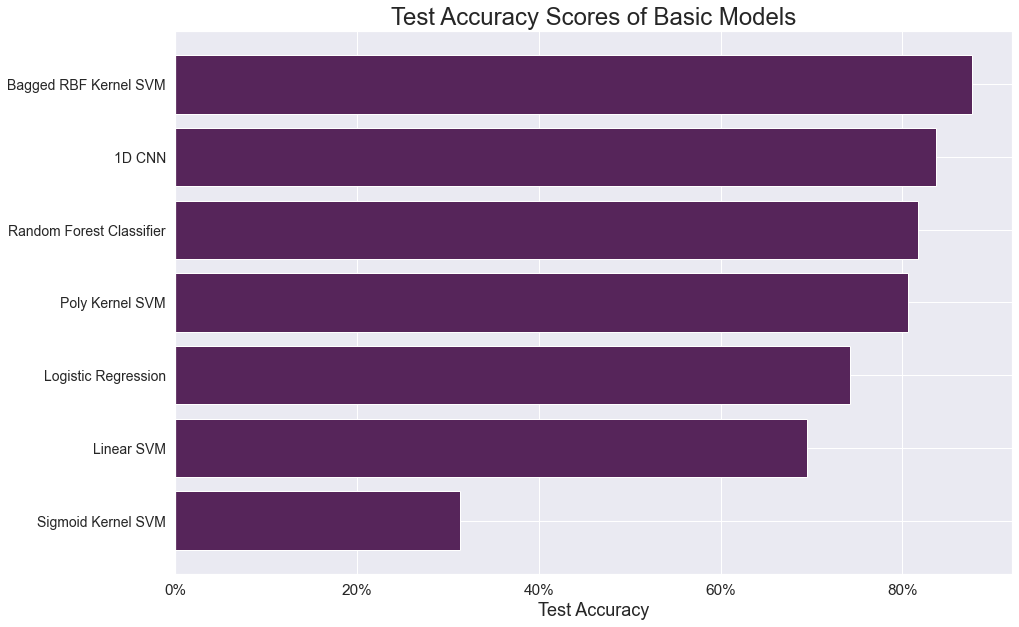

In [149]:
# Plotting the scores of the initial models
plt.figure(figsize=(15,10))
#test = prelimscores['Test Accuracy']
plt.barh(y = (prelim_model_scores['Model']) ,width= prelim_model_scores['Test Accuracy'], color = '#56255a')

plt.gca().set_xticklabels(['{:.0f}%'.format(y*100) for y in plt.gca().get_xticks()]) 
plt.xlabel('Test Accuracy', fontsize = 18)
plt.title('Test Accuracy Scores of Basic Models', fontsize=24)
plt.yticks(fontsize=14)

os.chdir('/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Presentation Materials')
plt.savefig('Test Accuracy of Basic Models.png', transparent=True,bbox_inches='tight')

plt.show()

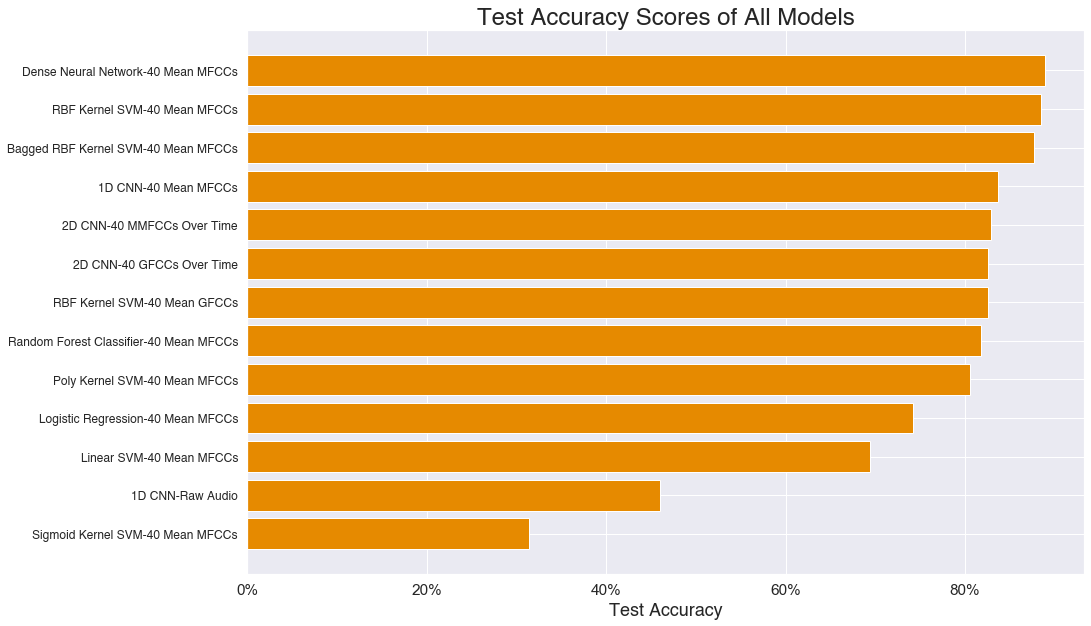

In [150]:
# Plotting results of all models
plt.figure(figsize=(15,10))
test = prelimscores['Test Accuracy']
plt.barh(y = (prelimscores['Model and Feature']) ,width= prelimscores['Test Accuracy'], color = '#e68a00')
hfont = {'fontname':'Helvetica'}

plt.gca().set_xticklabels(['{:.0f}%'.format(y*100) for y in plt.gca().get_xticks()]) 
plt.xlabel('Test Accuracy', fontsize = 18, **hfont)
plt.title('Test Accuracy Scores of All Models', fontsize=24, **hfont)
plt.yticks(fontsize=12, **hfont)

os.chdir('/Users/coleslatt/Documents/Data Science/Brainstation/Projects/Capstone Project/Presentation Materials')
plt.savefig('Test Accuracy of Models.png', transparent=True,bbox_inches='tight')

plt.show()

## Listening Test

Before we move on, we're going to do a listening test with our best model, to see what kinds of files get misclassified. We'll also take a look at the confusion matrix for that same model.

In [151]:
# This will run a listening test so we can hear all the audio samples that our model got wrong.
os.chdir(os.path.join(PATH,'Training Data'))
y_test = pd.read_csv('y_test',index_col=0)

predictions = pd.DataFrame(data=y_pred,index=y_test.index, columns=['Predicted'])

os.chdir(os.path.join(PATH,'DataFrames'))

raw_audio_np = np.load('raw_audio_np.npy', allow_pickle=True)
raw_audio_df = pd.DataFrame(raw_audio_np)

pred_vs_label = predictions.join(raw_audio_df)
pred_vs_label.rename({5: 'Label'}, axis=1,inplace=True)
pred_vs_label = pred_vs_label.query('Predicted != Label')

def label(x):
    
    if x==0:
        label = 'Anger'
    if x==1:
        label = 'Disgust'
    if x==2:
        label = 'Fear'
    if x==3:
        label = 'Sad'
    if x==4:
        label = 'Neutral'
    if x==5:
        label = 'Happy'
    if x==6:
        label = 'Surprised'
        
    return label

count=1
for i in range(pred_vs_label.shape[0]):
    
    print(f'{count}. {pred_vs_label.iloc[i,1]}')
    count+=1
    x = pred_vs_label.iloc[i]
    audio = pred_vs_label.iloc[i,6:]
    
    pred = x['Predicted']
    pred = label(pred)
    
    print(f'Predicted: {pred}')
    
    actual = x['Label']
    actual = label(actual)
    
    print(f'Actual: {actual}')
    
    display(ipd.Audio(audio, rate = 11000))

1. h08.wav
Predicted: Anger
Actual: Happy


2. h04.wav
Predicted: Fear
Actual: Happy


3. n18.wav
Predicted: Disgust
Actual: Neutral


4. f13.wav
Predicted: Surprised
Actual: Fear


5. f01.wav
Predicted: Neutral
Actual: Fear


6. a03.wav
Predicted: Fear
Actual: Anger


7. su10.wav
Predicted: Happy
Actual: Surprised


8. h15.wav
Predicted: Anger
Actual: Happy


9. a04.wav
Predicted: Surprised
Actual: Anger


10. sa03.wav
Predicted: Disgust
Actual: Sad


11. h07.wav
Predicted: Anger
Actual: Happy


12. su15.wav
Predicted: Fear
Actual: Surprised


13. sa01.wav
Predicted: Neutral
Actual: Sad


14. sa05.wav
Predicted: Anger
Actual: Sad


15. sa14.wav
Predicted: Neutral
Actual: Sad


16. f04.wav
Predicted: Surprised
Actual: Fear


17. sa03.wav
Predicted: Disgust
Actual: Sad


18. sa04.wav
Predicted: Anger
Actual: Sad


19. h03.wav
Predicted: Surprised
Actual: Happy


20. a08.wav
Predicted: Happy
Actual: Anger


## Demo with models

In [152]:
#Imports for live demo
import sounddevice as sd
from scipy.io.wavfile import write
sd.default.device = [0,1]

# Load models
os.chdir(os.path.join(PATH,'Models','Demo Models'))
 
RBF_kernel_SVM_MFCC = pickle.load(open('40 MFCCs RBF Kernel.sav', 'rb'))
RBF_kernel_SVM_GFCC = pickle.load(open('40 GFCCs RBF Kernel for DEMO.sav', 'rb'))
Dense_Model = load_model('Demo_Dense_Neural_Net.1')
GFCC_DENSE_MODEL = load_model('Dense NN 40 GFCC COMPLETE DATA FOR DEMO')
GFCC_2D_CNN = load_model('2D GFCC CNN.1')

In [153]:
# Use this to change input/output devices
sd.default.device = [0,1]
sd.query_devices()

> 0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
  2 Sonarworks Systemwide, Core Audio (2 in, 2 out)
  3 Soundflower (2ch), Core Audio (2 in, 2 out)
  4 Soundflower (64ch), Core Audio (64 in, 64 out)
  5 Loopback Audio, Core Audio (2 in, 2 out)
  6 Aggregate Device, Core Audio (0 in, 0 out)
  7 test_audio, Core Audio (2 in, 4 out)

### Functions

In [154]:
# Converting audio to MFCCS
def audio_to_mfcc(y,sr):

    if (type(y)!= np.ndarray):
        y = y.to_numpy()

    audio = y
    
    os.chdir(os.path.join(PATH,'DataFrames'))

    audiodata_balanced_w_mfcc = pd.read_csv("Balanced Audio Data with 40 MFCCs.csv", index_col=False)

    # Selecting X & y and splitting into train/test
    X = audiodata_balanced_w_mfcc.iloc[:,6:]
    y = audiodata_balanced_w_mfcc.iloc[:,5]
    
    scaler = StandardScaler()

    scaler.fit(X)
    
    mfcc_test = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc = 40, hop_length = 128)
    mfcc_test = np.mean(mfcc_test, axis=1)
    mfcc_test = mfcc_test.reshape((1,mfcc_test.shape[0]))
    mfcc_test = scaler.transform(mfcc_test)
    mfcc_test = mfcc_test.astype('float32')
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    plt.figure(figsize=(7,5))
    librosa.display.specshow(data=D, y_axis='mel')
    plt.title(f'Mel Scale Spectrogram of Voice Recording', fontsize=18)
    plt.ylabel("Quefrency", fontsize=12)
    plt.show()
    
    return mfcc_test


In [155]:
# Converting audio to GFCCS

import numpy as np
import scipy
import scipy.signal
import scipy.fftpack

from librosa import util
from librosa import filters
#from ..util.exceptions import ParameterError

from librosa.core.time_frequency import fft_frequencies
from librosa.core.audio import zero_crossings, to_mono
from librosa.core.spectrum import power_to_db, _spectrogram
from librosa.core.constantq import cqt, hybrid_cqt
from librosa.core.pitch import estimate_tuning
from spafe.fbanks.gammatone_fbanks import gammatone_filter_banks

def gfcc_test(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs):

    

    if S is None:
        S = power_to_db(gammaspectrogram(y=y, sr=sr, **kwargs))

    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_mfcc]

    if lifter > 0:
        M *= 1 + (lifter / 2) * np.sin(np.pi * np.arange(1, 1 + n_mfcc, dtype=M.dtype) / lifter)[:, np.newaxis]
        return M
    elif lifter == 0:
        return M
    else:
        raise ParameterError('MFCC lifter={} must be a non-negative number'.format(lifter))

        
        
def gammaspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512,
                   win_length=None, window='hann', center=True, pad_mode='reflect',
                   power=2.0, **kwargs):

    S, n_fft = _spectrogram(y=y, S=S, n_fft=n_fft, hop_length=hop_length, power=power,
                            win_length=win_length, window=window, center=center,
                            pad_mode=pad_mode)

    # Build a Mel filter
    #mel_basis = filters.mel(sr, n_fft, **kwargs)

    gamma_basis = gammatone_filter_banks(fs=sr,nfft=n_fft,nfilts=128)

    return np.dot(gamma_basis, S)


def audio_to_gfcc(y,sr):

    audio = y

    os.chdir(os.path.join(PATH,'DataFrames'))
    audiodata_balanced_w_gfcc = pd.read_csv("Balanced Audio Data with 40 mean GFCCs.csv", index_col=False)

    # Selecting X & y and splitting into train/test
    X = audiodata_balanced_w_gfcc.iloc[:,6:]
    y = audiodata_balanced_w_gfcc.iloc[:,5]

    scaler = StandardScaler()
    scaler.fit(X)
    
    gfcc = gfcc_test(y=audio, sr=sr, n_mfcc = 40, hop_length = 128)
    
    gfcc = np.mean(gfcc, axis=1)
    gfcc = gfcc.reshape((1,gfcc.shape[0]))
    gfcc = scaler.transform(gfcc)
    gfcc = gfcc.astype('float32')

    return gfcc


def audio_to_gfcc_full(y,sr):

    audio = y
    
    pad_length = 292688 - len(y)
    audio = np.pad(audio,((0,pad_length)),'constant')

    gfcc_full = gfcc_test(y=audio, sr=sr, n_mfcc = 40,hop_length = 512)
    
    gfcc_full = gfcc_full.astype('float32')
    
    gfcc_full = gfcc_full.reshape((1,gfcc_full.shape[0],gfcc_full.shape[1],1))

    return gfcc_full

In [156]:
# Converting labels back to emotion
# 0 = anger, 1 = disgust, 2 = fear, 3 = sad, 4 = neutral, 5 = happy , 6 = surprised
def to_emotion(x):
    if x==0:
        emo = 'Anger'
    if x==1:
        emo = 'Disgust'
    if x==2:
        emo = 'Fear'
    if x==3:
        emo = 'Sad'
    if x==4:
        emo = 'Neutral'
    if x==5:
        emo = 'Happy'
    if x==6:
        emo = 'Surprised'
        
    return emo
        

In [157]:
# Assembling predictions from 4-5 models and returning the most probable emotion
def assemble_predictions(y,sr):
    
    MFCC_40 = audio_to_mfcc(y,sr)
    
    GFCC_40 = audio_to_gfcc(y,sr)
    
    GFCC_full = audio_to_gfcc_full(y,sr)
    
    svm_proba = RBF_kernel_SVM_MFCC.predict_proba(MFCC_40)
    nn_proba = Dense_Model.predict(MFCC_40)
    svm_gfcc_proba = RBF_kernel_SVM_GFCC.predict_proba(GFCC_40)
    gfcc_dense_proba = GFCC_DENSE_MODEL.predict(GFCC_40)
    gfcc_2d_cnn_proba = GFCC_2D_CNN.predict(GFCC_full)
    
    #proba = (nn_proba)*(svm_proba)*(svm_gfcc_proba)*(gfcc_dense_proba)*(gfcc_2d_cnn_proba)
    proba = (nn_proba)*(svm_proba)*(svm_gfcc_proba)*(gfcc_2d_cnn_proba)
    
    
    predictions_df = pd.DataFrame()
    predictions_df=predictions_df.append(pd.DataFrame((svm_proba),index=['MFCC SVM']),ignore_index=False)
    predictions_df=predictions_df.append(pd.DataFrame((nn_proba),index=['MFCC Neural Net']),ignore_index=False)
    predictions_df=predictions_df.append(pd.DataFrame((svm_gfcc_proba),index=['GFCC SVM']),ignore_index=False)
    predictions_df=predictions_df.append(pd.DataFrame((gfcc_dense_proba),index=['GFCC Neural Net']),ignore_index=False)
    predictions_df=predictions_df.append(pd.DataFrame((gfcc_2d_cnn_proba),index=['GFCC 2D CNN']),ignore_index=False)
    predictions_df=predictions_df.append(pd.DataFrame((proba),index=['Multiplied Probabilites']),ignore_index=False)
    predictions_df.columns=['Anger','Disgust','Fear','Sad','Neutral', 'Happy', 'Surprised']
    
    pred = np.argmax(proba,axis=1)[0]
    
    emo = to_emotion(pred)
    
    return emo, display(predictions_df)

### Live Demo

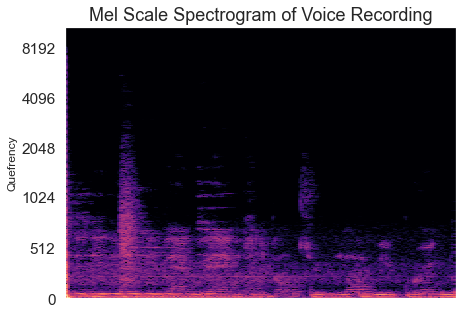

Anger       Disgust          Fear  \
MFCC SVM                 3.014352e-01  1.347159e-02  4.686595e-01   
MFCC Neural Net          4.652886e-03  4.780875e-03  9.420034e-01   
GFCC SVM                 4.618600e-02  4.852283e-02  1.290912e-01   
GFCC Neural Net          1.250915e-11  3.345297e-12  7.277769e-09   
GFCC 2D CNN              2.075328e-08  8.523771e-06  5.713508e-01   
Multiplied Probabilites  1.344354e-12  2.663815e-11  3.256188e-02   

                                  Sad       Neutral         Happy  \
MFCC SVM                 2.750432e-02  3.237839e-02  1.497139e-01   
MFCC Neural Net          5.606215e-03  1.075248e-04  4.118374e-02   
GFCC SVM                 6.159603e-01  7.566987e-02  7.970342e-02   
GFCC Neural Net          2.376014e-13  4.856396e-13  1.000000e+00   
GFCC 2D CNN              4.284411e-01  1.164267e-04  7.320647e-05   
Multiplied Probabilites  4.069251e-05  3.067179e-11  3.597612e-08   

                            Surprised  
MFCC SVM                 6.836999e-03  
MFCC Neural Net          1.665296e-03  
GFCC SVM                 4.866329e-03  
GFCC Neural Net          1.877068e-15  
GFCC 2D CNN              1.000787e-05  
Multiplied Probabilites  5.544981e-13

Fear


In [158]:
# Live demo voice test, it'll record for 2.5 seconds and estimate your emotion based on your voice.

sr = 41000  # Sample rate
seconds = 2.5  # Duration of recording

y = sd.rec(int(seconds * sr), samplerate=sr, channels=1) #Record Incoming Audio
sd.wait()  # Wait until recording is finished

y = y.reshape(y.shape[0])


display(ipd.Audio(y,rate=sr)) #Play the audio clip

tell_me_what_imfeeling = assemble_predictions(y,sr) #Make predictions
print(tell_me_what_imfeeling[0]) #Show me the prediction

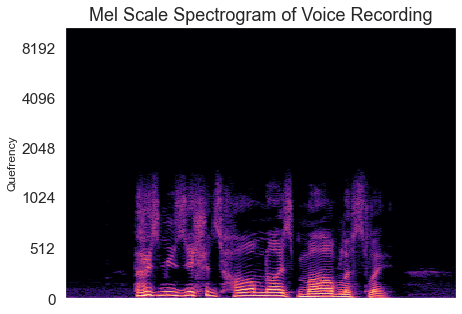

Anger   Disgust      Fear           Sad  \
MFCC SVM                 1.551746e-01  0.026378  0.711355  9.522091e-03   
MFCC Neural Net          2.599582e-02  0.038772  0.042852  9.386975e-03   
GFCC SVM                 2.448290e-01  0.247530  0.167057  6.861941e-02   
GFCC Neural Net          4.704363e-04  0.000780  0.997246  6.598558e-04   
GFCC 2D CNN              3.993680e-05  0.006865  0.007475  3.283906e-07   
Multiplied Probabilites  3.944213e-08  0.000002  0.000038  2.014168e-12   

                              Neutral     Happy     Surprised  
MFCC SVM                 3.151774e-02  0.065448  6.039688e-04  
MFCC Neural Net          5.922426e-03  0.872280  4.790426e-03  
GFCC SVM                 1.780183e-01  0.077884  1.606316e-02  
GFCC Neural Net          2.405603e-04  0.000567  3.641101e-05  
GFCC 2D CNN              2.703092e-07  0.985618  1.112617e-06  
Multiplied Probabilites  8.982144e-12  0.004382  5.170889e-14

'Happy'

In [159]:
# Sampling some audio files
os.chdir(os.path.join(PATH,'Data Sets'))
y, sr = librosa.load(('SAVEE/JE/h04.wav'), sr = 41000)
display(ipd.Audio(y,rate=sr))
assemble_predictions(y,sr)[0]

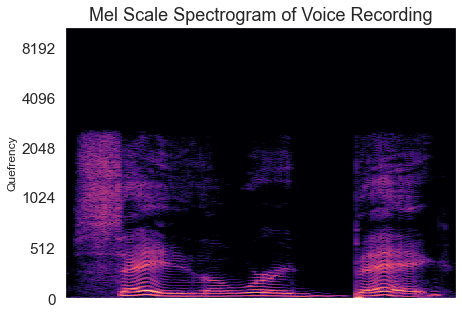

Anger   Disgust          Fear           Sad  \
MFCC SVM                 1.956689e-01  0.114363  1.069757e-02  9.803495e-04   
MFCC Neural Net          2.874835e-16  1.000000  6.907463e-14  3.841819e-10   
GFCC SVM                 4.152910e-03  0.825301  5.817408e-03  1.509975e-01   
GFCC Neural Net          5.945637e-15  1.000000  5.733955e-17  1.679524e-20   
GFCC 2D CNN              2.700669e-04  0.999719  3.644461e-08  7.744887e-06   
Multiplied Probabilites  6.308973e-23  0.094357  1.566630e-25  4.404560e-19   

                              Neutral         Happy     Surprised  
MFCC SVM                 1.577484e-03  6.760968e-01  6.162472e-04  
MFCC Neural Net          1.235986e-14  8.258983e-15  4.438816e-21  
GFCC SVM                 8.590617e-03  4.866952e-03  2.731629e-04  
GFCC Neural Net          1.641070e-18  5.110363e-17  6.672774e-25  
GFCC 2D CNN              2.305120e-07  2.579087e-07  2.244395e-06  
Multiplied Probabilites  3.860969e-26  7.009039e-24  1.677039e-33

'Disgust'

In [160]:
# Sampling some audio files
os.chdir(os.path.join(PATH,'Data Sets'))
y, sr = librosa.load(('TESS/OAF_disgust/OAF_beg_disgust.wav'), sr = 41000)
display(ipd.Audio(y,rate=sr))
assemble_predictions(y,sr)[0]

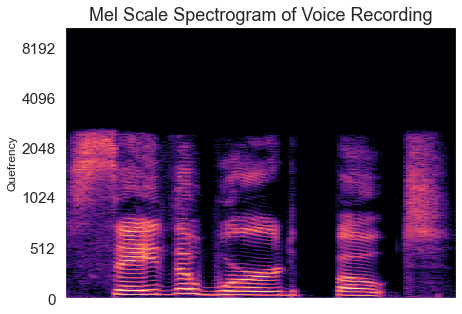

Anger   Disgust      Fear           Sad   Neutral  \
MFCC SVM                 0.861264  0.105893  0.018270  8.281317e-03  0.000685   
MFCC Neural Net          1.000000  0.000000  0.000000  0.000000e+00  0.000000   
GFCC SVM                 0.798686  0.076640  0.013487  9.645026e-02  0.006468   
GFCC Neural Net          1.000000  0.000000  0.000000  0.000000e+00  0.000000   
GFCC 2D CNN              0.999178  0.000003  0.000535  4.292709e-09  0.000001   
Multiplied Probabilites  0.687315  0.000000  0.000000  0.000000e+00  0.000000   

                                Happy  Surprised  
MFCC SVM                 5.088147e-03   0.000518  
MFCC Neural Net          0.000000e+00   0.000000  
GFCC SVM                 7.490243e-03   0.000778  
GFCC Neural Net          9.711061e-38   0.000000  
GFCC 2D CNN              2.713992e-04   0.000011  
Multiplied Probabilites  0.000000e+00   0.000000

'Anger'

In [161]:
# Sampling some audio files
os.chdir(os.path.join(PATH,'Data Sets'))
y, sr = librosa.load(('TESS/YAF_angry/YAF_boat_angry.wav'), sr = 41000)
display(ipd.Audio(y,rate=sr))
assemble_predictions(y,sr)[0]

## Resource List

### Datasets

__TESS__

Pichora-Fuller, M. Kathleen; Dupuis, Kate, 2020, "Toronto emotional speech set (TESS)", https://doi.org/10.5683/SP2/E8H2MF, Scholars Portal Dataverse, V1 

https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

__SAVEE__

http://kahlan.eps.surrey.ac.uk/savee/


### Learning Resources

The following resources have provided with valuable information about how to best address problems and topics encountered throughout this project.

__https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/__

__https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc__

__https://www.researchgate.net/publication/322602563_Databases_features_and_classifiers_for_speech_emotion_recognition_a_review__

__https://www.kaggle.com/papeloto/urban-sound-feature-extraction-knn/notebook__

__https://www.kaggle.com/ejlok1/audio-emotion-part-1-explore-data__


__https://medium.com/neuronio/how-to-deal-with-image-resizing-in-deep-learning-e5177fad7d89__

__https://stackoverflow.com/questions/56091965/how-to-get-gfcc-instead-of-mfcc-in-python__

__https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6__

__https://arxiv.org/pdf/1703.04770.pdf__